In [2]:
import haiku as hk
import h5py
import os
import sys
sys.path.append(os.path.abspath("birdflow/birdflow-bilevel/src/"))
from flow_model_training import loss_fn, mask_input, Datatuple, train_model, w2_loss_fn
from flow_model import model_forward
from hdfs import get_plot_parameters
import numpy as np
import optax
from functools import partial
from jax import jit
import jax.numpy as jnp
from ott.geometry.pointcloud import PointCloud
from ott.geometry.geometry import Geometry
from ott.geometry.costs import CostFn
from ott.solvers import linear
from ott.solvers.linear.implicit_differentiation import ImplicitDiff
import jax
from jaxtyping import Float, Array, Int
from typing import Any, Union
import functools
from tqdm import tqdm
import matplotlib.pyplot as plt
from beartype import (
    beartype,
    BeartypeConf,
    BeartypeStrategy,
)
import pickle

%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype

## Learning an S&T distribution with W2 distance

In [3]:
hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_39km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.1
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

In [6]:
def make_grid(marginal, mask, big_mask, x_dim, y_dim):
    """
    Arguments
    week: the week whose marginal we wish to fill into the grid to be plotted
    marginal: the marginal from week "week"
    mask: the dynamic mask.
    big_mask: the mask used to eliminate oceans
    x_dim: number of columns of final grid
    y_dim: number of rows of the final grid

    Returns:
    A grid with all the densities of the weekly marginals filled in
    """
    medium_grid = np.zeros(mask.shape[0])
    medium_grid[mask] = marginal
    big_grid = np.empty(big_mask.shape[0])
    big_grid.fill(np.nan)
    big_grid[big_mask] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

In [7]:
eps_defaults = []
for i, distance_matrix in enumerate(distance_matrices_for_week):
    geom = Geometry(cost_matrix=distance_matrix, epsilon=None)
    eps_defaults.append(geom.epsilon)

In [8]:
print(masked_densities[0])
print(jnp.sum(masked_densities[0]))
print(jnp.mean(distance_matrices_for_week[0]))
print(jnp.max(distance_matrices_for_week[0]))
print(jnp.min(distance_matrices_for_week[0]))
print(jnp.std(distance_matrices_for_week[0]))

[2.75533562e-06 1.19970601e-05 2.14966816e-05 ... 1.55415614e-07
 2.91564749e-07 4.37049889e-08]
1.0
1.2297753
1.4226154
0.0
0.09399295


In [9]:
sinkhorn_solver = jit(linear.solve, static_argnames=['max_iterations', 'progress_fn'])

class Scheduler:
    @beartype(conf=BeartypeConf(strategy=(BeartypeStrategy.O0)))
    def __init__(self, target, init, decay, decay_after):
        self.target = target
        self.init = init
        self.decay = decay
        self.decay_after = decay_after
    
    def get_epsilon(self, it: Int[Array, ""]):
        """
        At training step it, get a value of epsilon
        """
        epsilon = self.init * self.target
        epsilon = jax.lax.cond(it > self.decay_after,
                     lambda t : jax.lax.cond(t - self.decay * (it - self.decay_after) > self.target, lambda s : t - self.decay * (it - self.decay_after), lambda s: self.target, None),
                     lambda t: t,
                     epsilon)  # linear decay   
        return epsilon

def w2_distance(mu: Float[Array, "n "], mu_true: Float[Array, "n "], distance_matrix: Float[Array, "n n"], epsilon: Union[Float[Array, ""], Any]):
    geom = Geometry(cost_matrix=distance_matrix, epsilon=epsilon)
    ot = sinkhorn_solver(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return ot.reg_ot_cost

def loss_fn(theta: Float[Array, "n "], st_marginal: Float[Array, "n "], distance_matrix: Float[Array, "n n"], epsilon: Union[Float[Array, ""], Any]):
    mu = jax.nn.softmax(theta)
    return w2_distance(mu, st_marginal, distance_matrix, epsilon)

def logit_l2_loss(theta: Float[Array, "n "], marginal: Float[Array, "n "]):
    """
    l2 distance between logits and probability distribution
    """
    mu = jax.nn.softmax(theta)
    return jnp.sqrt(jnp.sum((mu - marginal)**2))

def learn_st_marginal(st_marginal: Float[Array, "n"], 
                      distance_matrix: Float[Array, "n n"], 
                      seed=42,
                      training_steps=500, 
                      epsilon: Union[float, Any]=None, 
                      tau: float=1.0, 
                      lr: float=1e-3, 
                      init_from_mu_true: bool=False, 
                      use_adam: bool=True, 
                      use_stabilization: bool=False, 
                      scheduler: Union[Scheduler, Any]=None,
                      loss_fn=loss_fn):
    
    solver = optax.adam(learning_rate=lr)
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    
    # if init_from_mu_true:  # initialize at the true marginal
    #     mu_true_logits = jnp.log(mu_true)
    #     theta_init = mu_true_logits
    # else:
    #     theta_init = jnp.zeros(shape=X.shape[0]) # uniform initialization

    # initialize parameter values
    theta_init = jnp.zeros(shape=st_marginal.shape[0]) # uniform initialization    
    
    # initialize solver
    theta = theta_init
    opt_state = solver.init(theta)
    
    # create loss function
    loss_fn = functools.partial(loss_fn, st_marginal=st_marginal, distance_matrix=distance_matrix)
    grad_loss_fn = jax.value_and_grad(loss_fn)
    
    @jax.jit
    def make_step_adam(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon=epsilon)
        updates, opt_state = solver.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        return loss_val, theta, opt_state
    
    @jax.jit
    def make_step(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon)
        theta = theta - lr * grads
        return loss_val, theta, None
    
    @jax.jit
    def make_step_stabilized(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon)
        theta = theta - lr * grads
        
        # stabilize by subtracting max from theta
        theta = theta - jnp.max(theta) # softmax(X - c) = softmax(X) 
        
        return loss_val, theta, None
    
    if use_adam:
        make_step = make_step_adam
    if use_stabilization:
        make_step = make_step_stabilized
    
    w2_loss_vals = []
    l2_loss_vals = []
    thetas = {}
    if scheduler != None:
        get_epsilon = jax.jit(scheduler.get_epsilon)
    for step in tqdm(range(1, training_steps + 1), desc="Training Steps", unit="step"):
        if scheduler != None:
            epsilon = float(get_epsilon(step))
        loss_val, theta, opt_state = make_step(theta, epsilon, opt_state)
        if step % int(training_steps / 40) == 0:
            thetas[step] = theta
        w2_loss_vals.append(loss_val)
        l2_loss_val = logit_l2_loss(theta, st_marginal)
        l2_loss_vals.append(l2_loss_val)
        #print(f"iteration {step}, loss value {loss_val}, l2 loss: {l2_loss_val}")
    
    return theta, thetas, (w2_loss_vals, l2_loss_vals)

### Experiment 1
2000 training steps

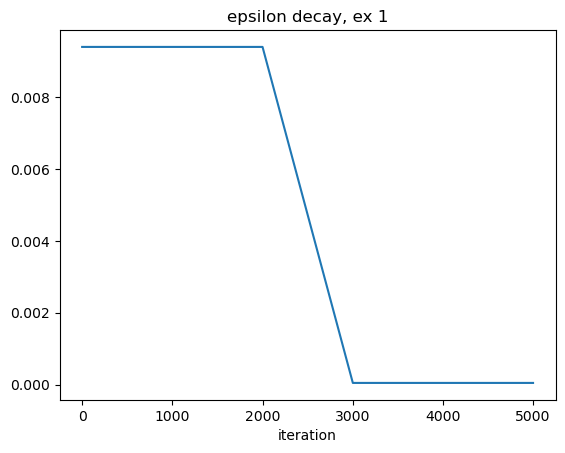

In [57]:
xs = jnp.arange(0, 5000, 1)
week = 0
eps_default = eps_defaults[week]
scheduler = Scheduler(eps_default * 0.01, 200, 9.352196e-06, 2000)
get_epsilon = jax.jit(scheduler.get_epsilon)
ys = [float(get_epsilon(x)) for x in xs]
plt.plot(xs, ys)
#plt.axvline(x = 2, color='red', linestyle='--')
plt.title("epsilon decay, ex 1")
plt.xlabel("iteration")
plt.show()

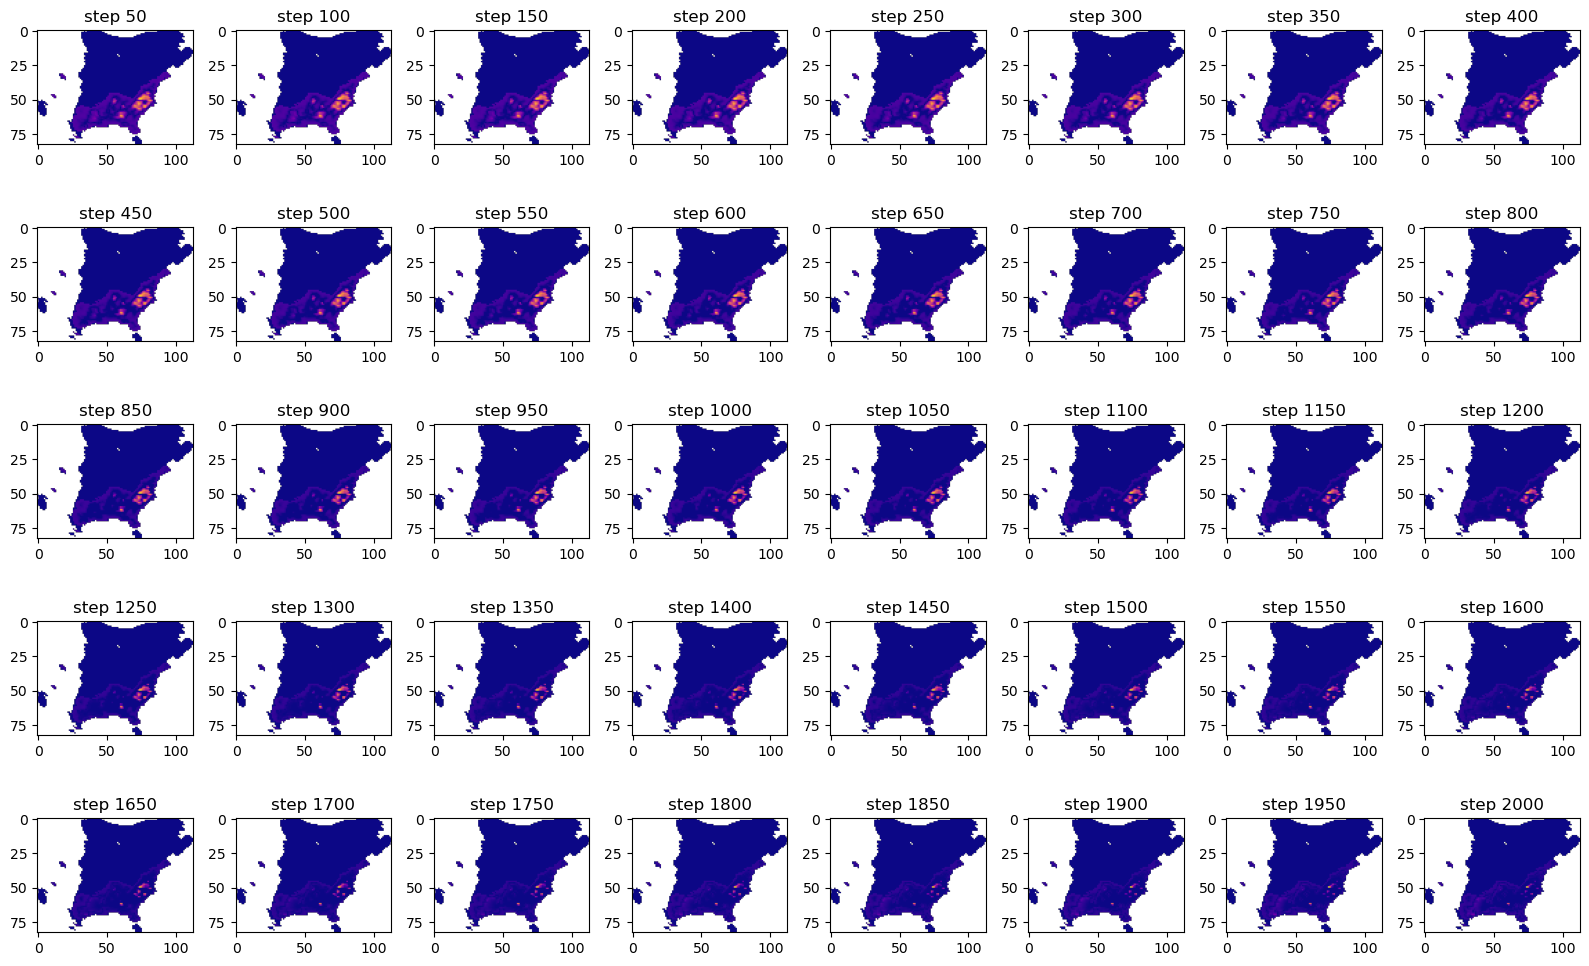

In [62]:
experiment_pkl_path = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/learn-st-marginal-week0.pkl'
with open(experiment_pkl_path, 'rb') as f:
    data = pickle.load(f)
learned = data['learned']
thetas = data['thetas']
w2_loss_vals = data['w2_loss_vals']
l2_loss_vals = data['l2_loss_vals']
week = 0
st_marginal = jnp.array(masked_densities[week])

# plot difference between learned / ground truth st at each step
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_st = jax.nn.softmax(theta)
    grid_learned = make_grid(learned_st, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
    diff_grid = jnp.abs(grid_learned - grid_true)
    pos = ax_list[i].imshow(diff_grid, cmap="plasma")
    ax_list[i].set_title(f"step {step}")
    # ax_list[i].colorbar(pos)
    
plt.tight_layout()
plt.show()

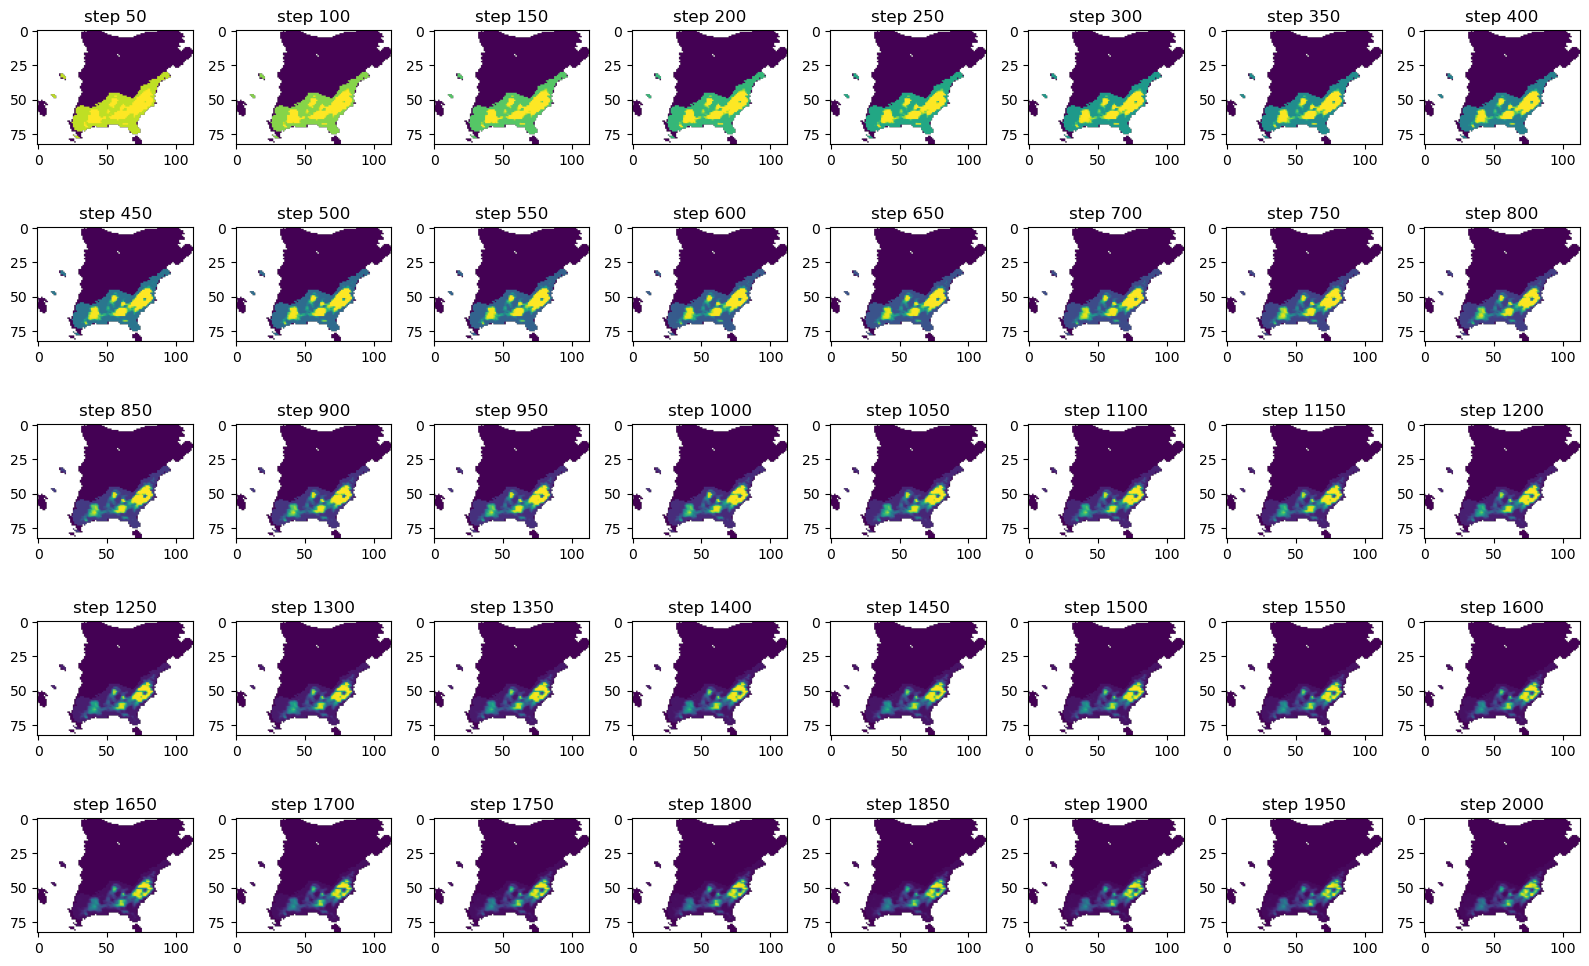

In [63]:
# plot learned at each timestep
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_st = jax.nn.softmax(theta)
    grid_learned = make_grid(learned_st, dynamic_masks[week], big_mask, ncol, nrow)
    # grid_true = make_grid(st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
    # diff_grid = jnp.abs(grid_learned - grid_true)
    pos = ax_list[i].imshow(grid_learned, cmap="viridis")
    ax_list[i].set_title(f"step {step}")
    # ax_list[i].colorbar(pos)
    
plt.tight_layout()
plt.show()

0.0 0.006355739198625088


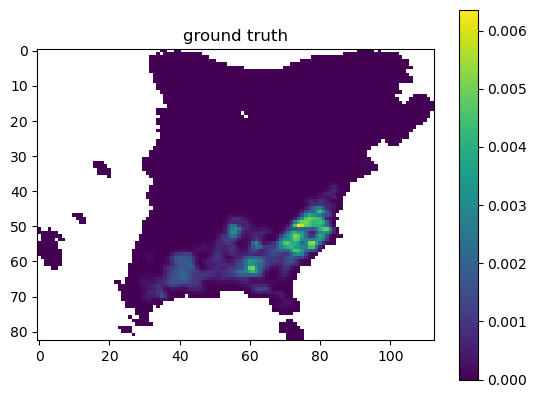

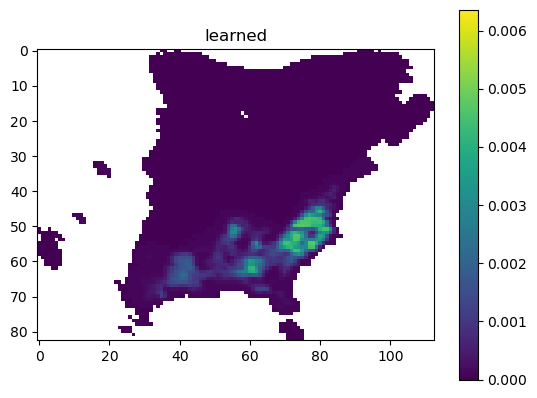

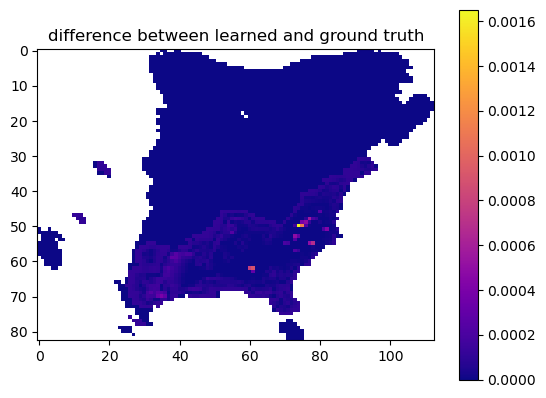

In [69]:
# plot ground truth
grid_true = make_grid(st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
learned_st_marginal = jax.nn.softmax(learned)
grid_learned = make_grid(learned_st_marginal, dynamic_masks[week], big_mask, ncol, nrow)

grid_true_vals = grid_true.flatten()
grid_true_vals = grid_true_vals[~np.isnan(grid_true_vals)]
grid_learned_vals = grid_learned.flatten()
grid_learned_vals = grid_learned_vals[~np.isnan(grid_learned_vals)]

vmin = min(grid_true_vals.min(), grid_learned_vals.min())
vmax = max(grid_true_vals.max(), grid_learned_vals.max())
print(vmin, vmax)

plt.figure(1)
pos = plt.imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar(pos)
plt.title("ground truth")

plt.figure(2)
pos = plt.imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar(pos)
plt.title("learned")

plt.figure(3)
diff_grid = jnp.abs(grid_true - grid_learned)
pos = plt.imshow(diff_grid, cmap="plasma")
plt.colorbar(pos)
plt.title("difference between learned and ground truth")
plt.show()

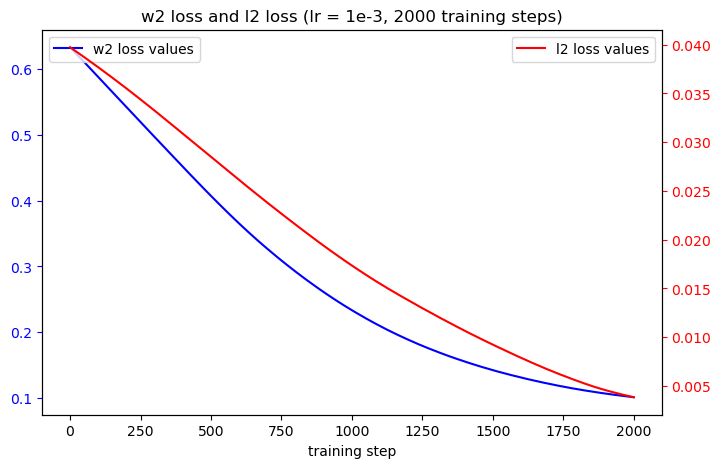

In [70]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(2000)), w2_loss_vals, 'b', label='w2 loss values')
#ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(2000)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
#ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = 1e-3, 2000 training steps)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

## Training with the full model

### Experiment 1
- Markov chain
- 600 training steps
- Standard observation loss
- ew: 1e-4, dw: 1e-2, ow: 1, dp: 0.4

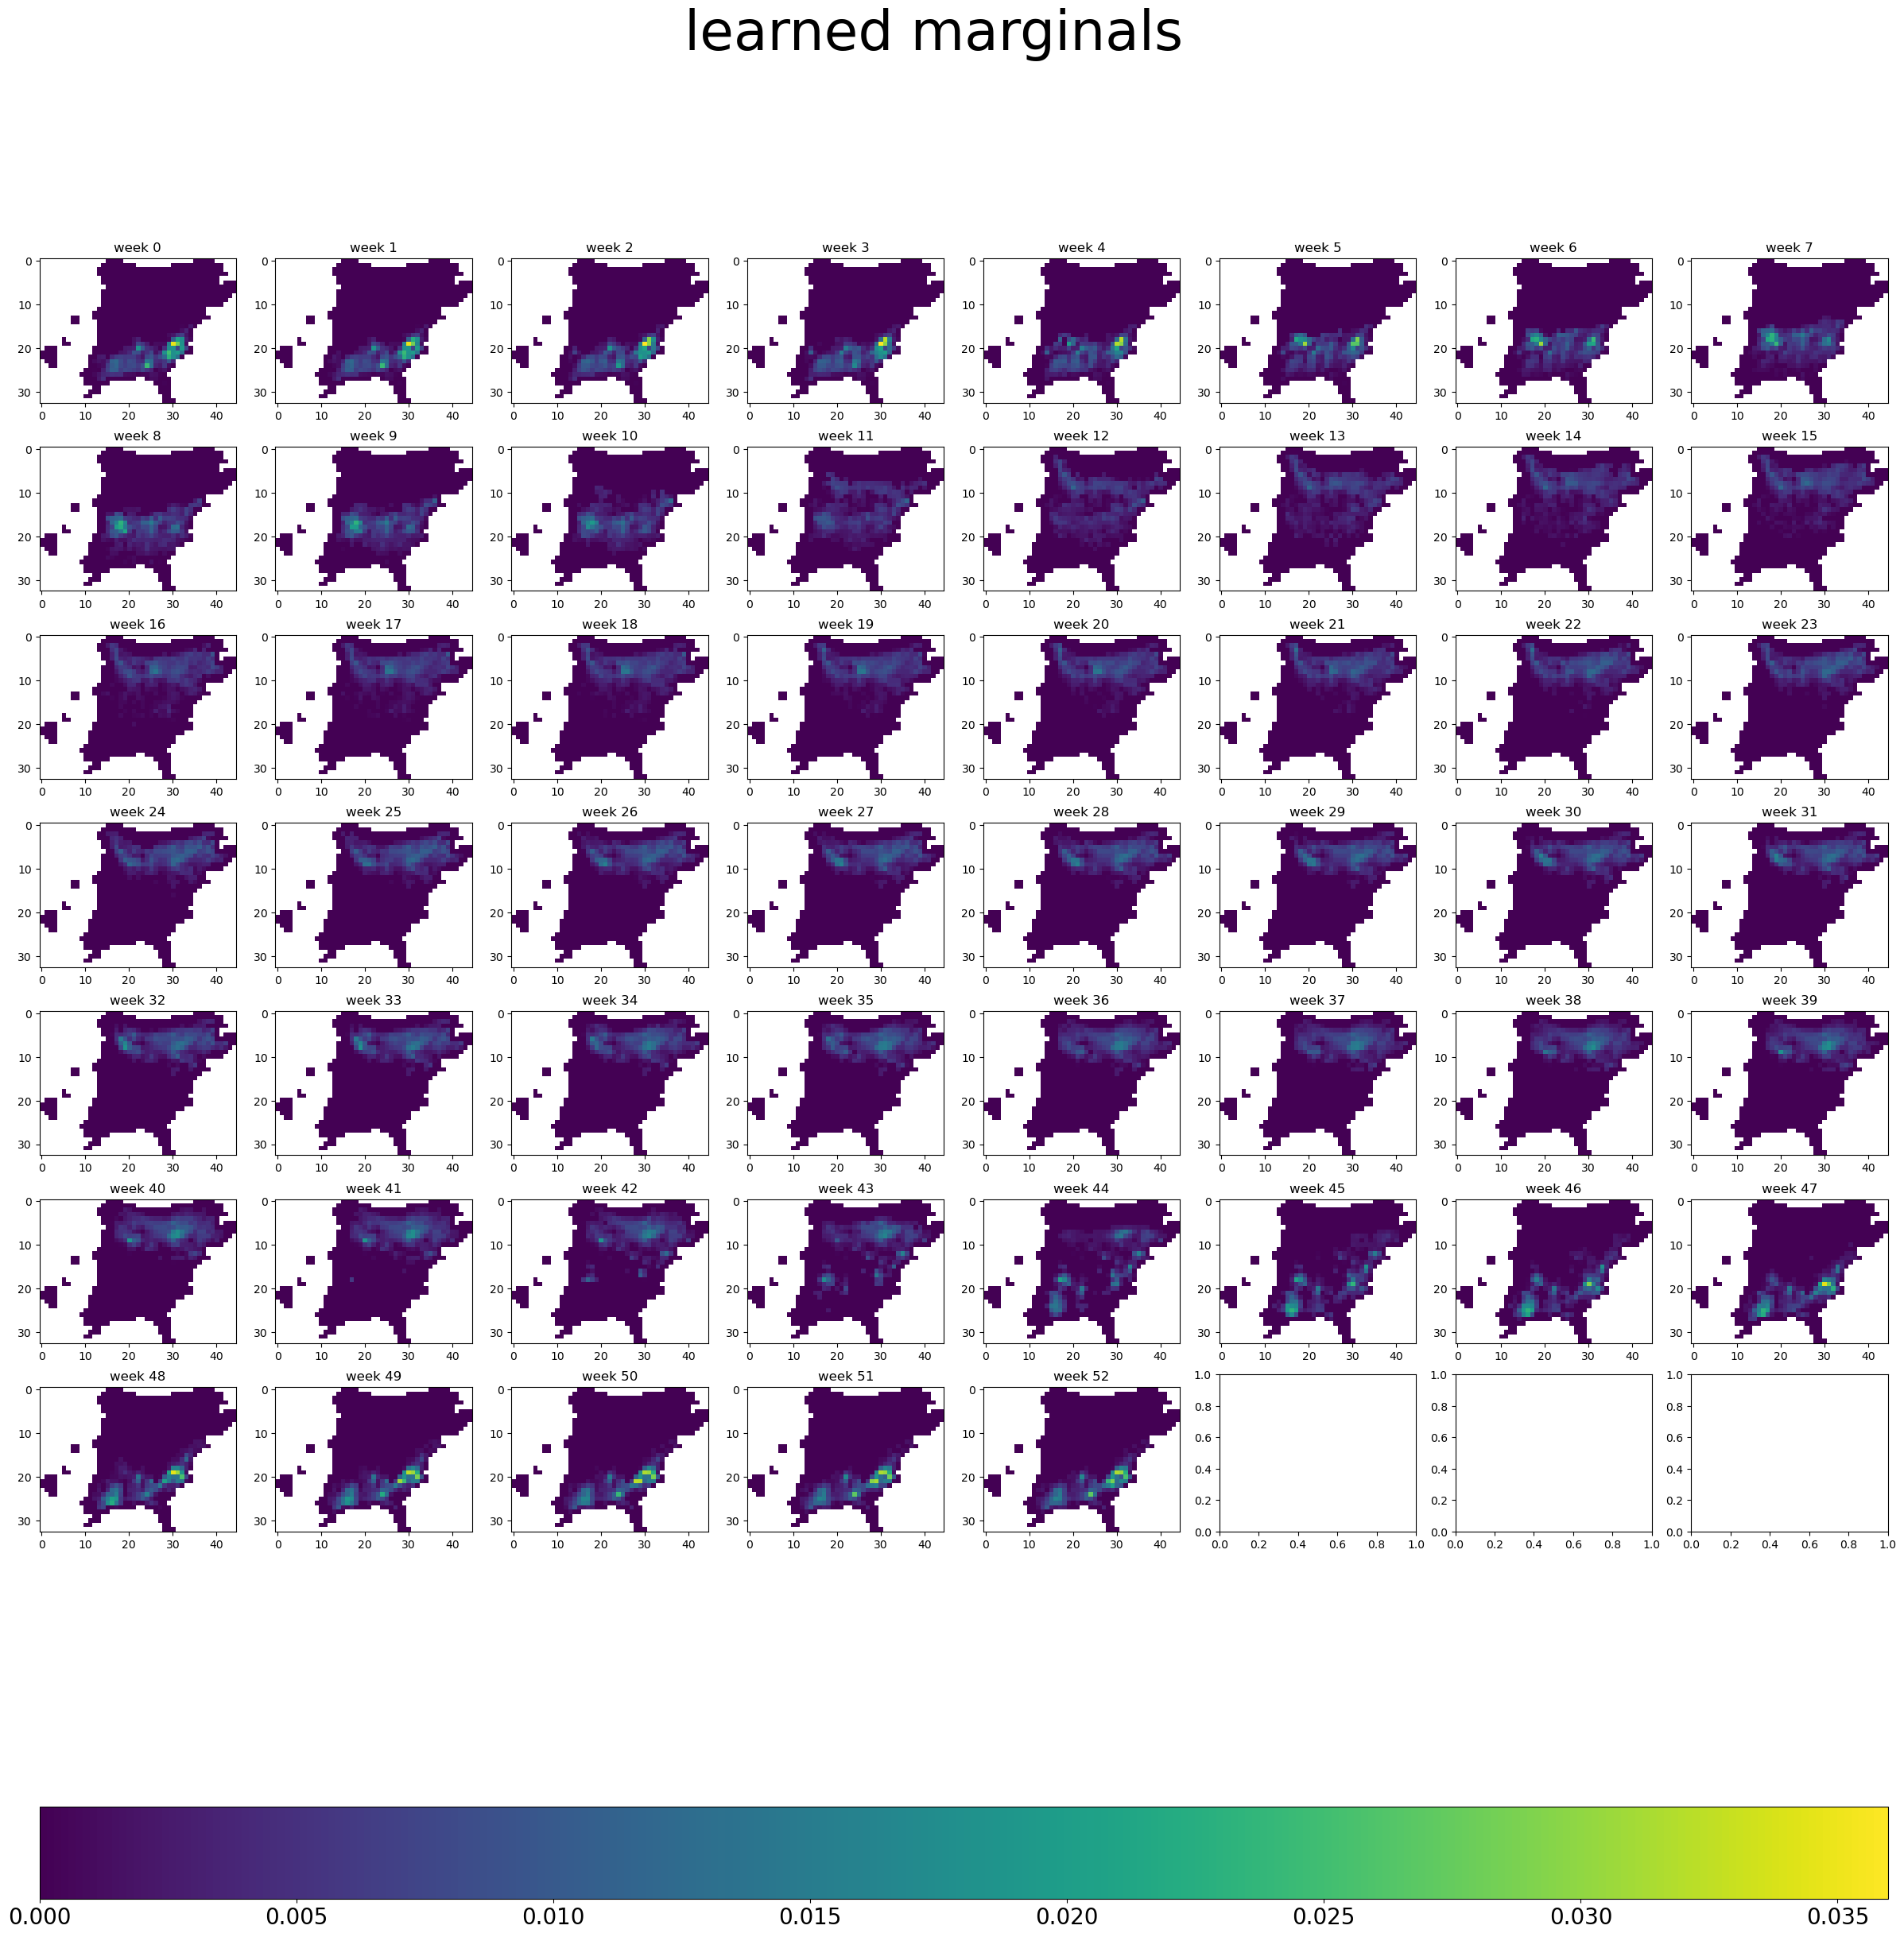

In [10]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'params_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(t_start, t_end):
        z = params[f'Flow_Model/Week_{week}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()


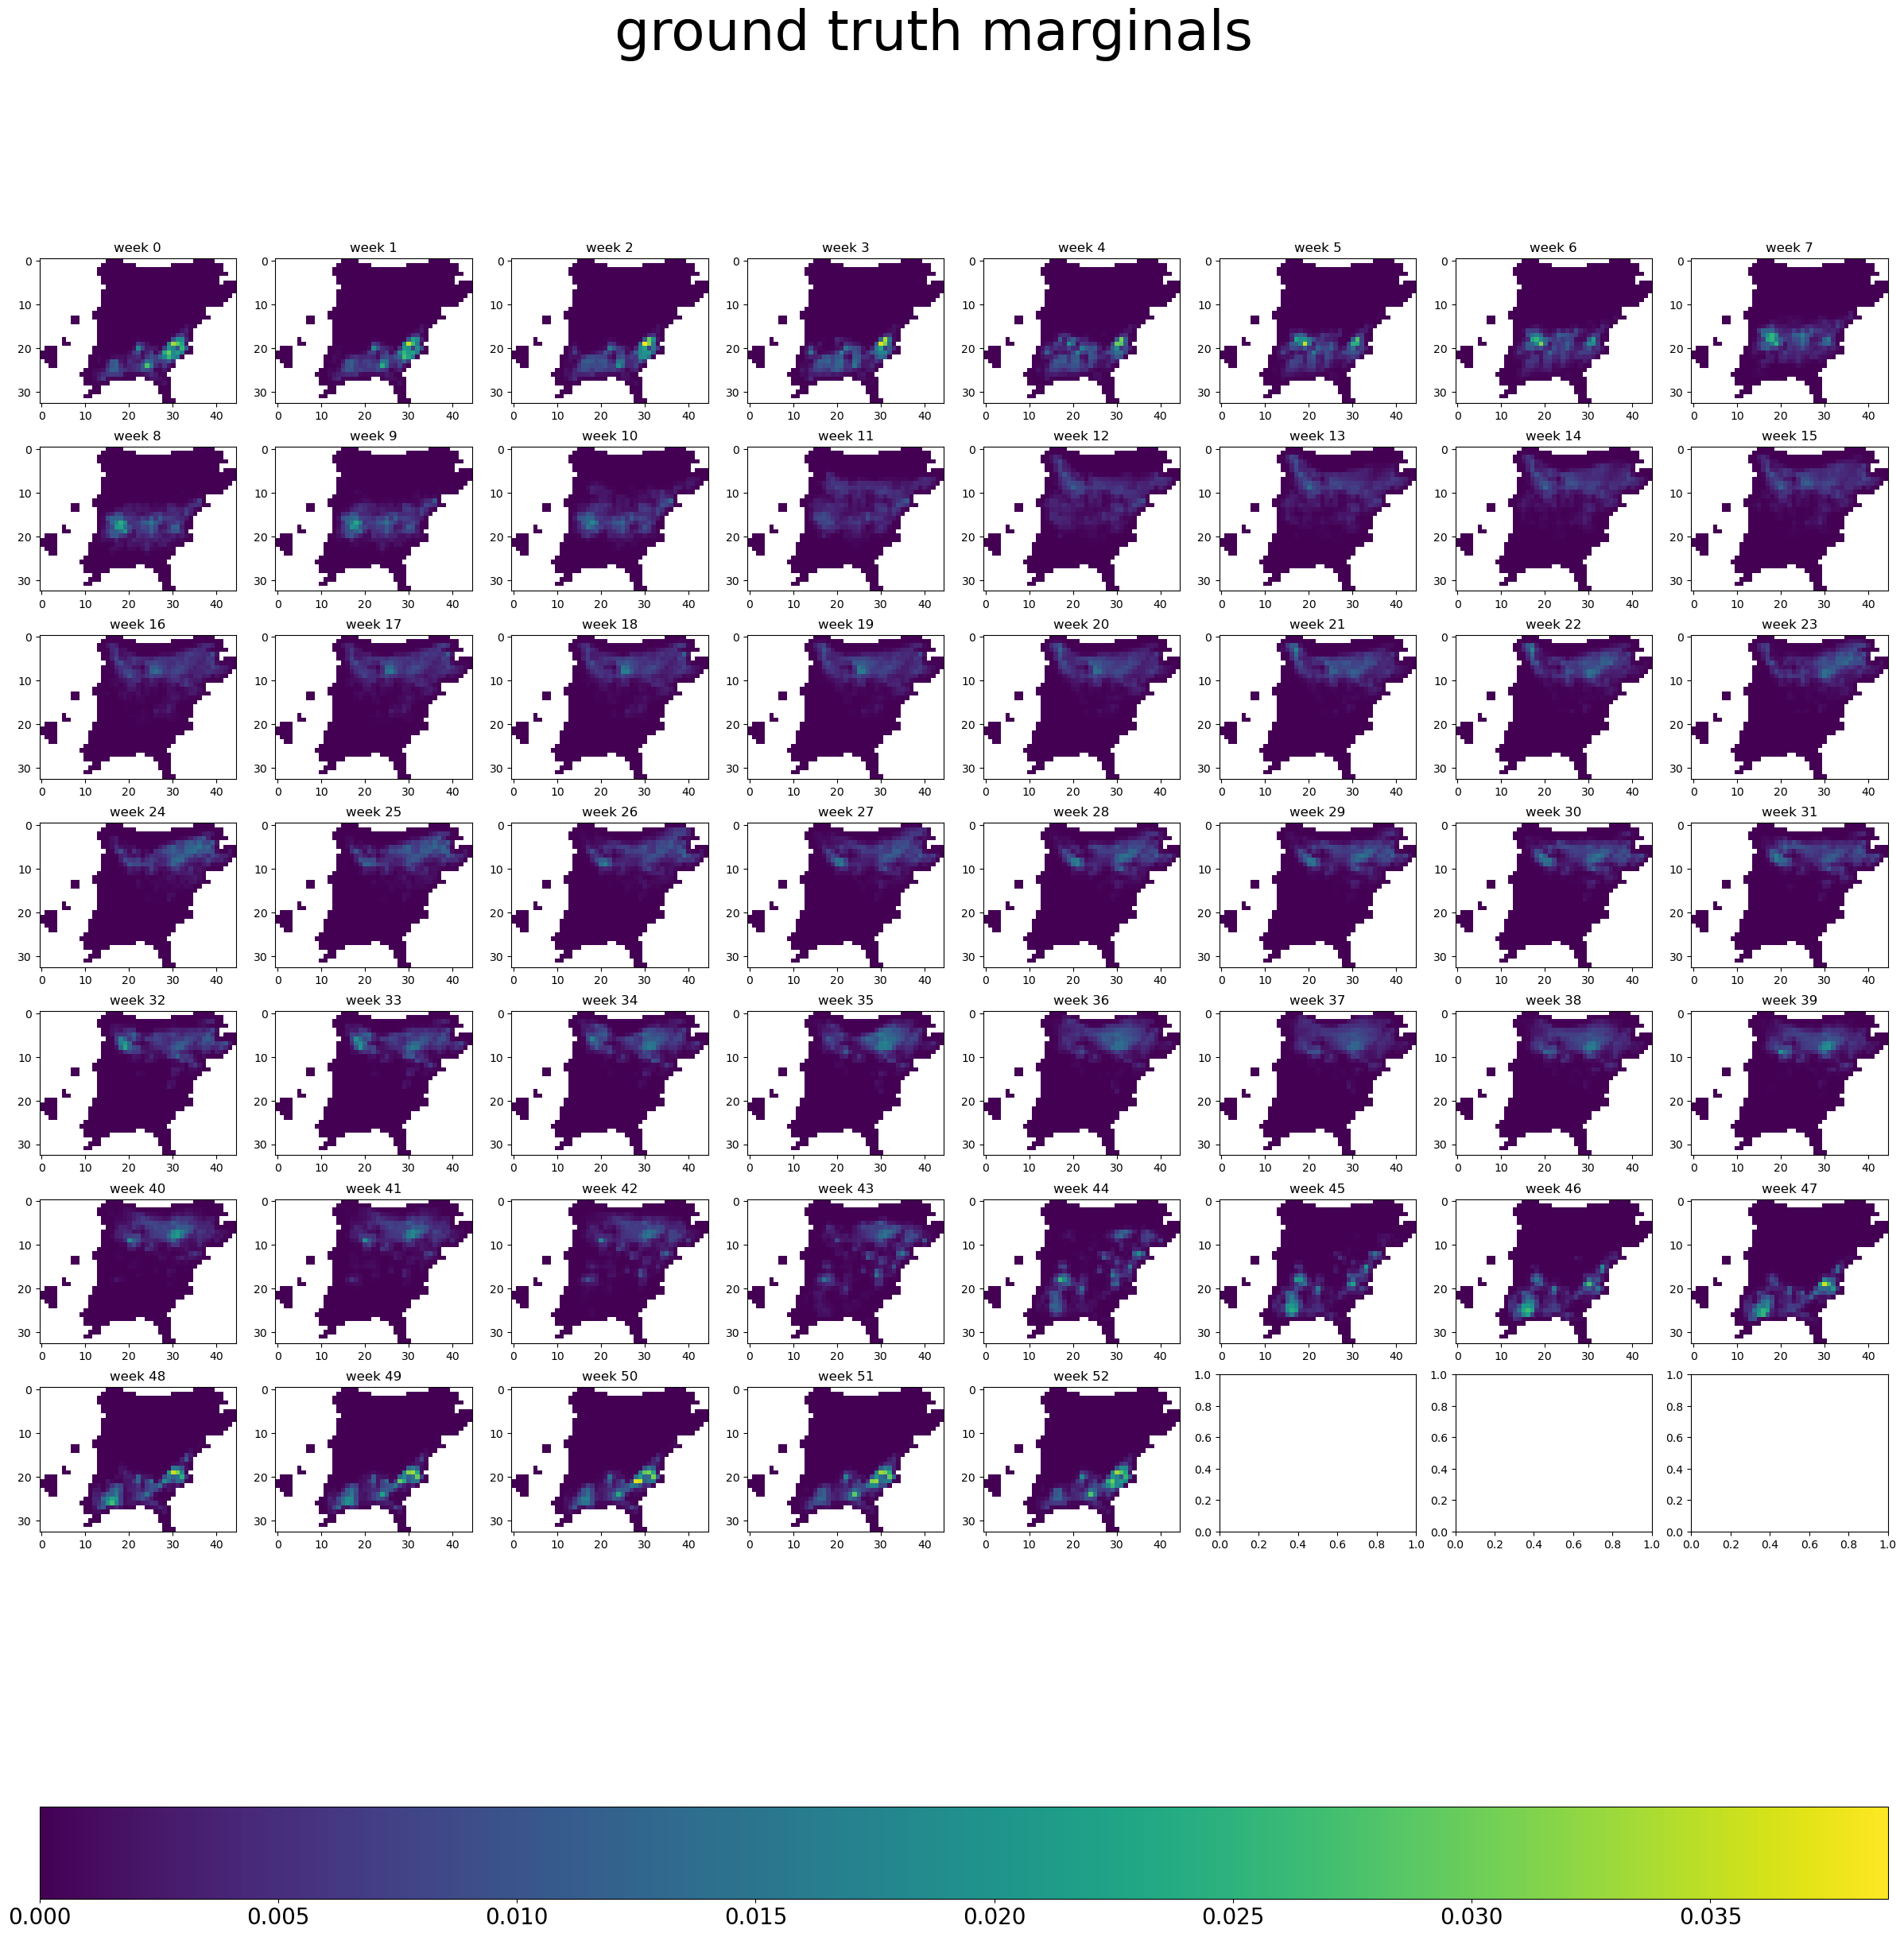

In [113]:
# plot ground truth at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in masked_densities])
for week, marginal in enumerate(masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

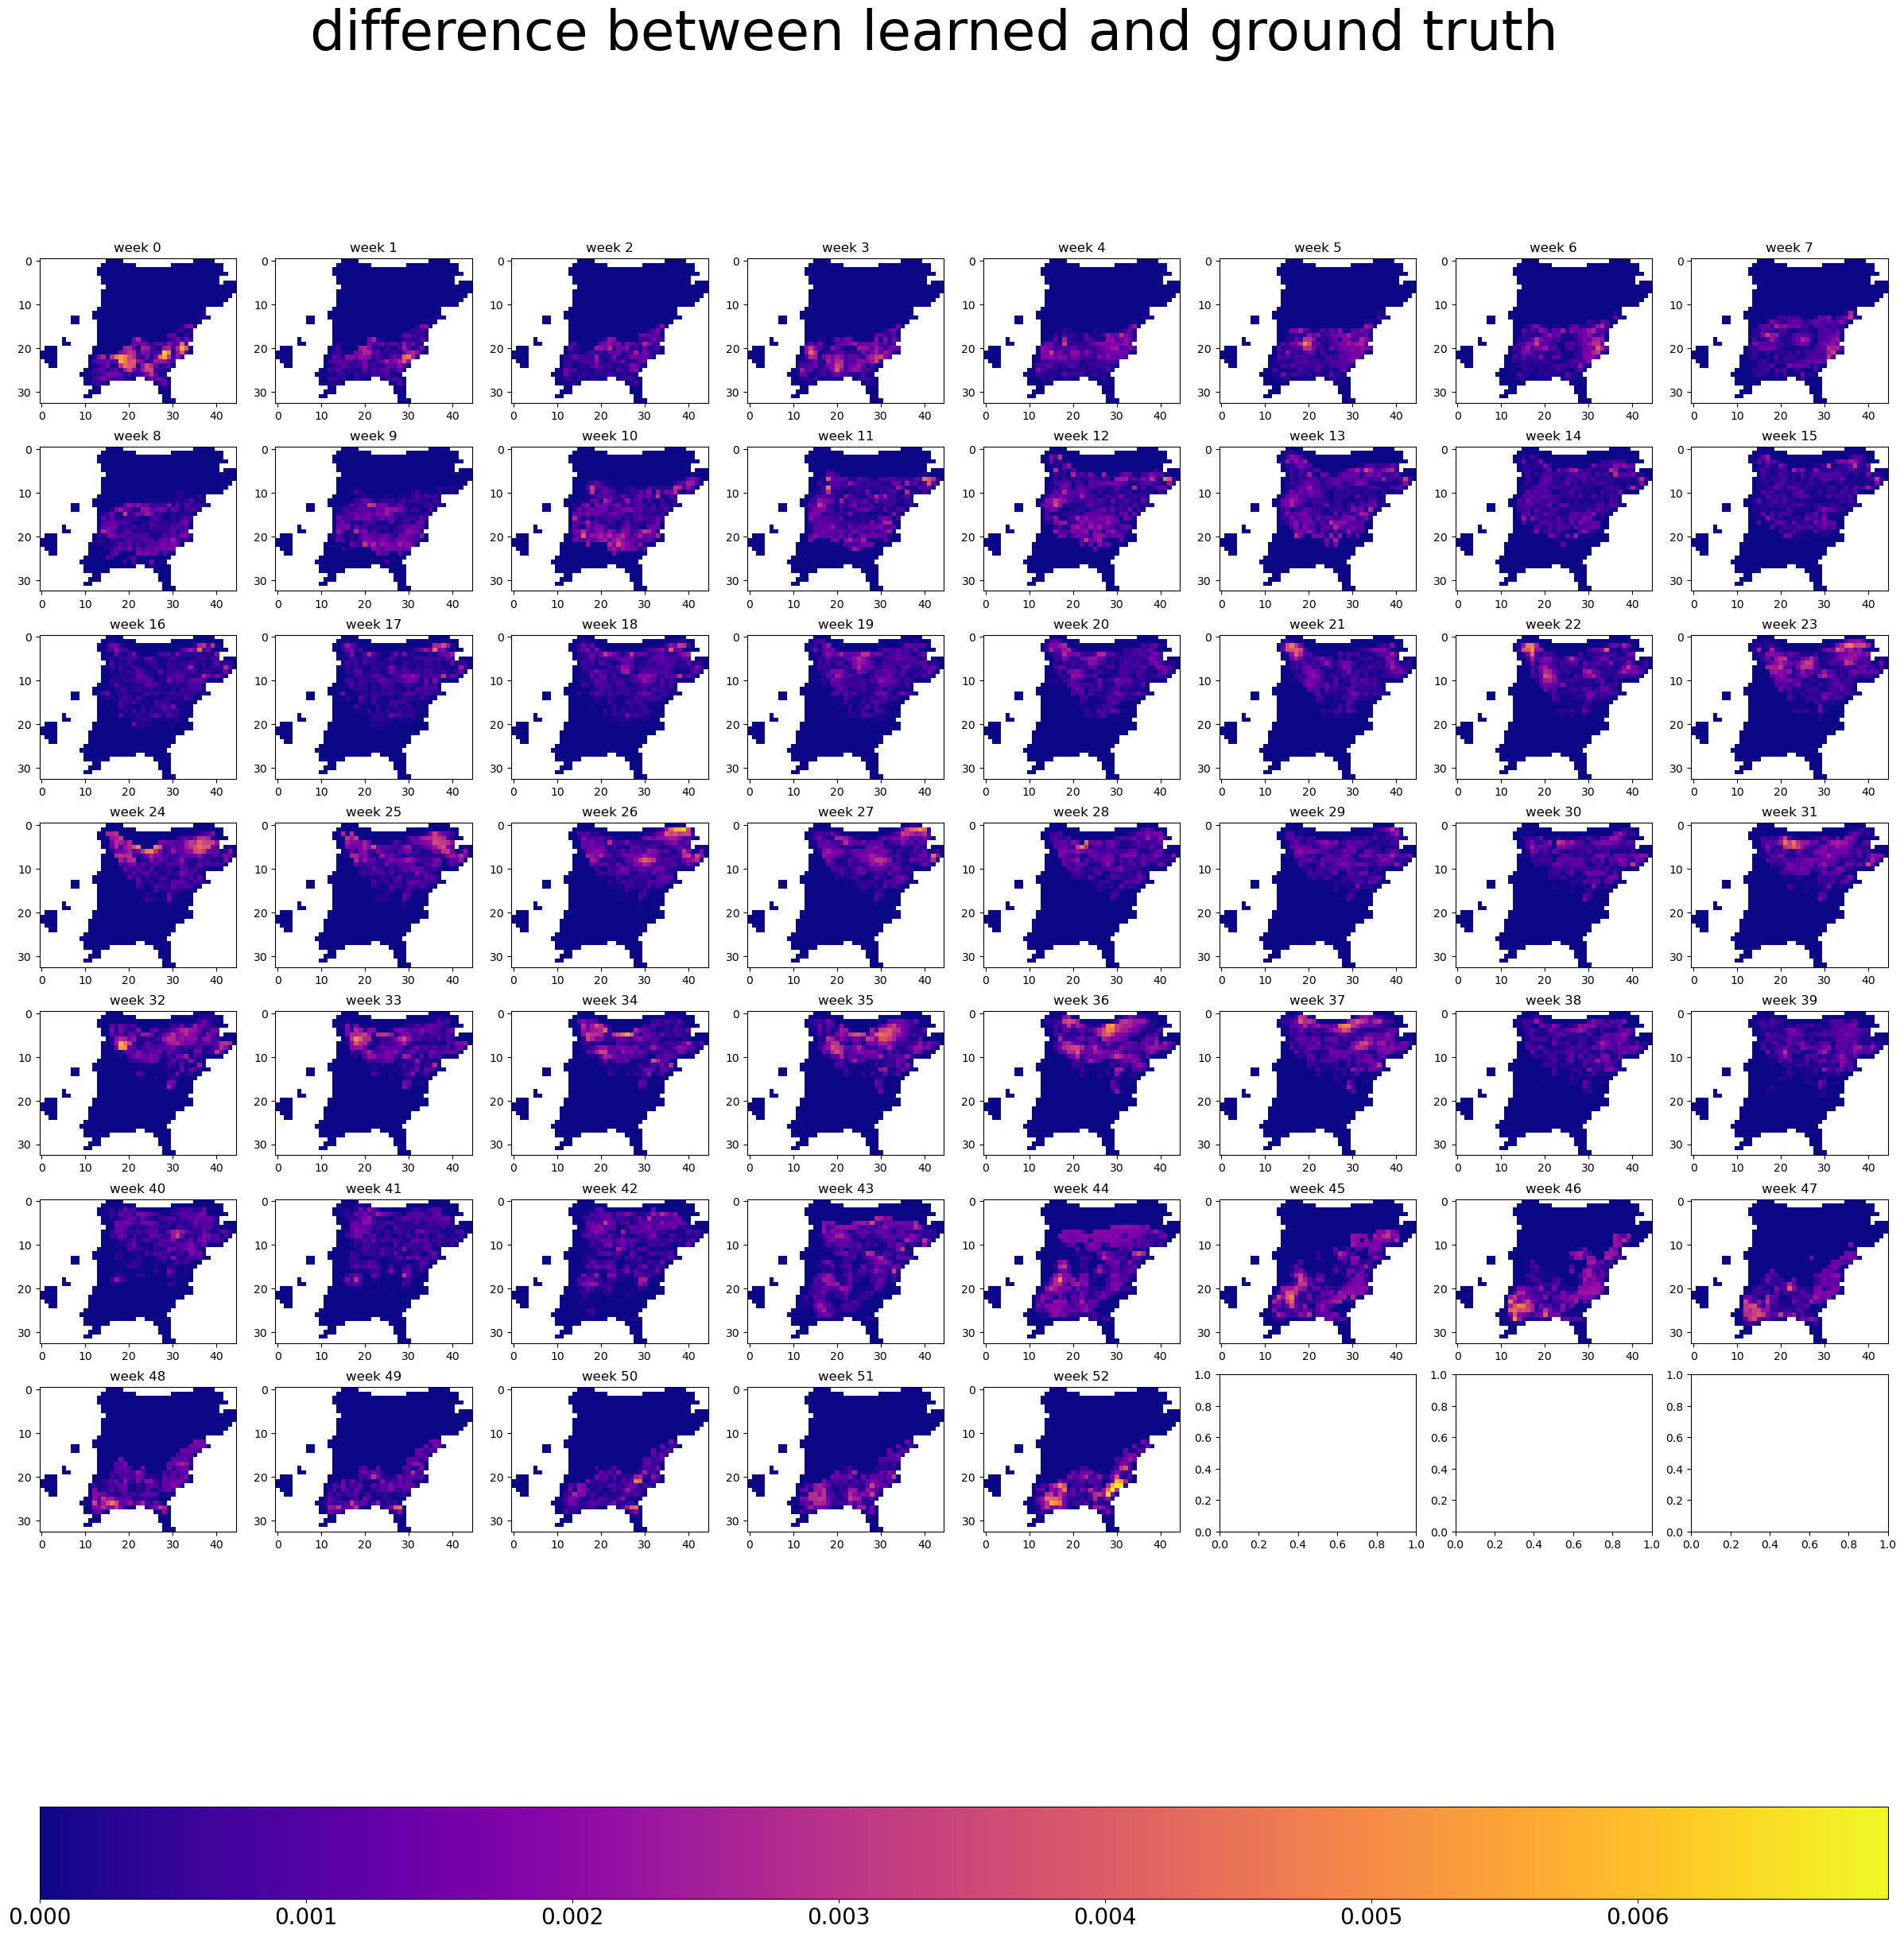

In [109]:
# plot difference between learned and ground truth for each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

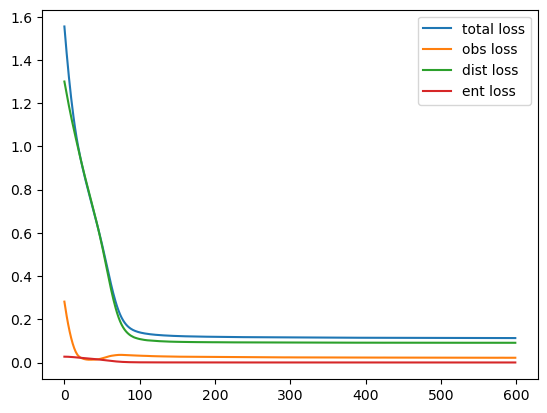

In [120]:
ent_weight = 1e-4
dist_weight = 1e-2
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['total'], label='total loss')
plt.plot(jnp.arange(num_iters), loss_dict['obs'], label='obs loss')
plt.plot(jnp.arange(num_iters), dist_weight * jnp.array(loss_dict['dist']), label='dist loss')
plt.plot(jnp.arange(num_iters), ent_weight * jnp.array(loss_dict['ent']), label='ent loss')
plt.legend()
plt.show()

### Experiment 2
- Markov chain
- 600 training steps
- Standard observation loss
- ew: 0, dw: 0, ow: 1, dp: 0.4

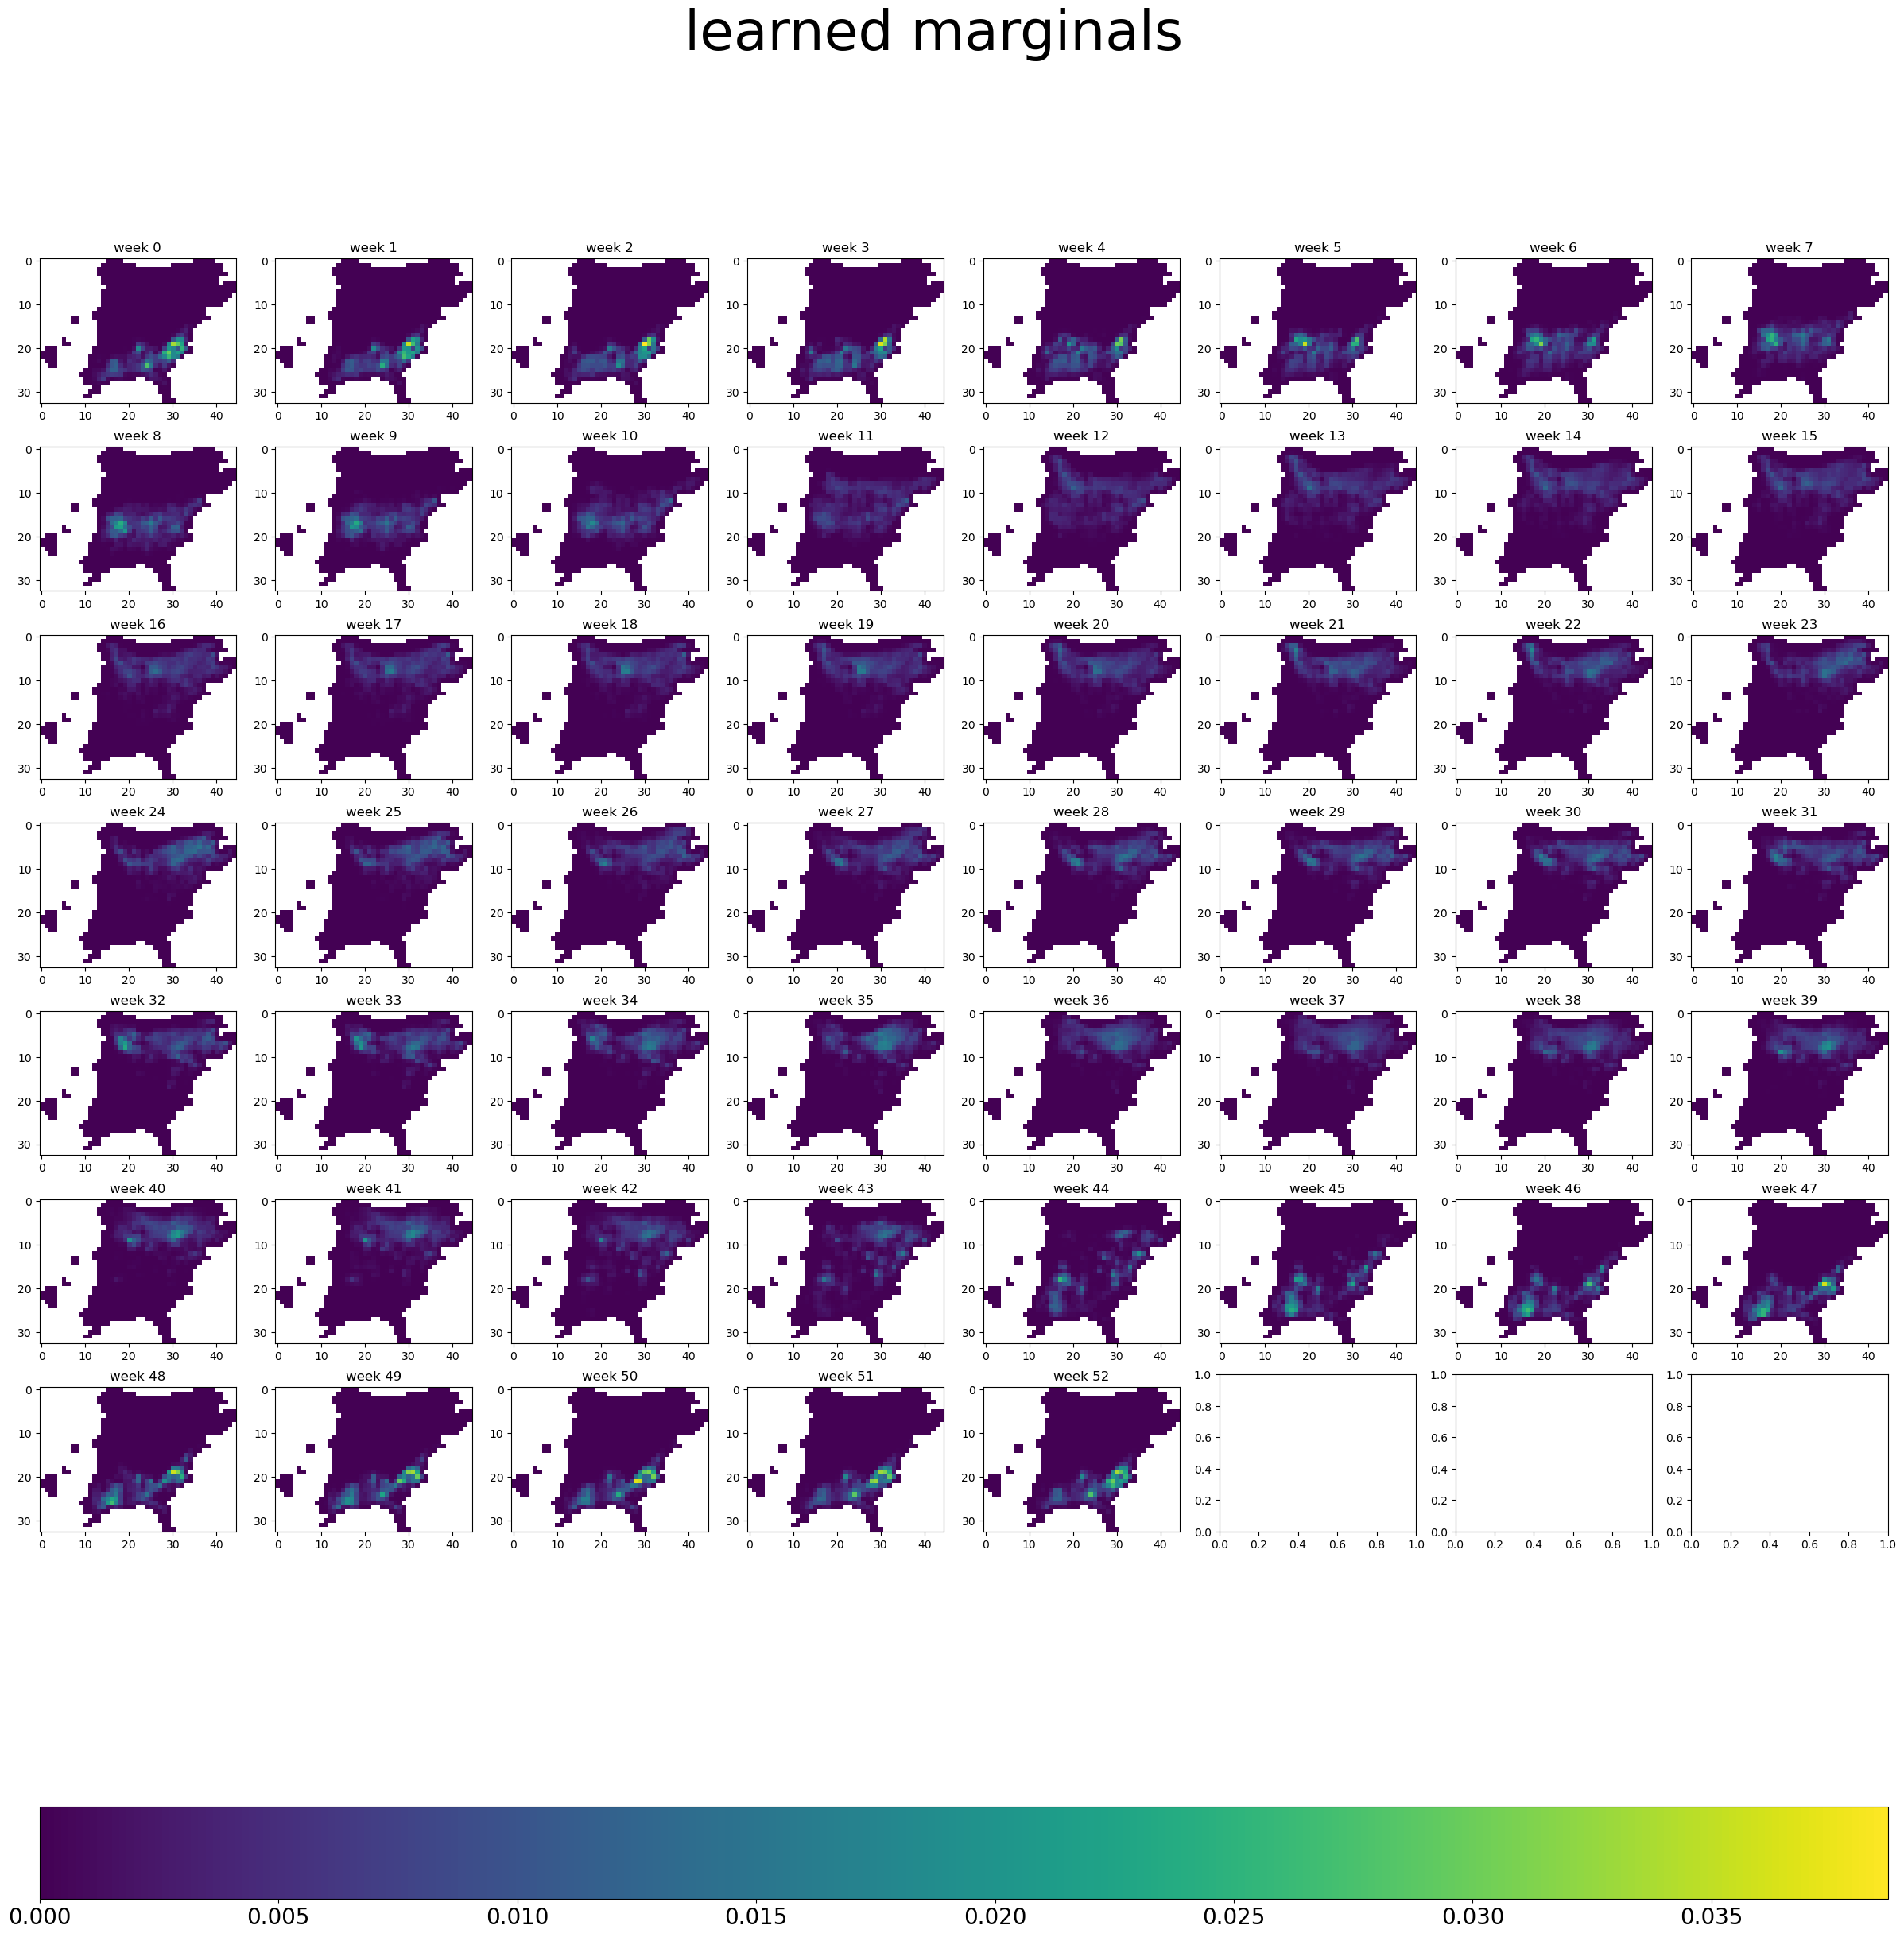

In [121]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'params_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(t_start, t_end):
        z = params[f'Flow_Model/Week_{week}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()


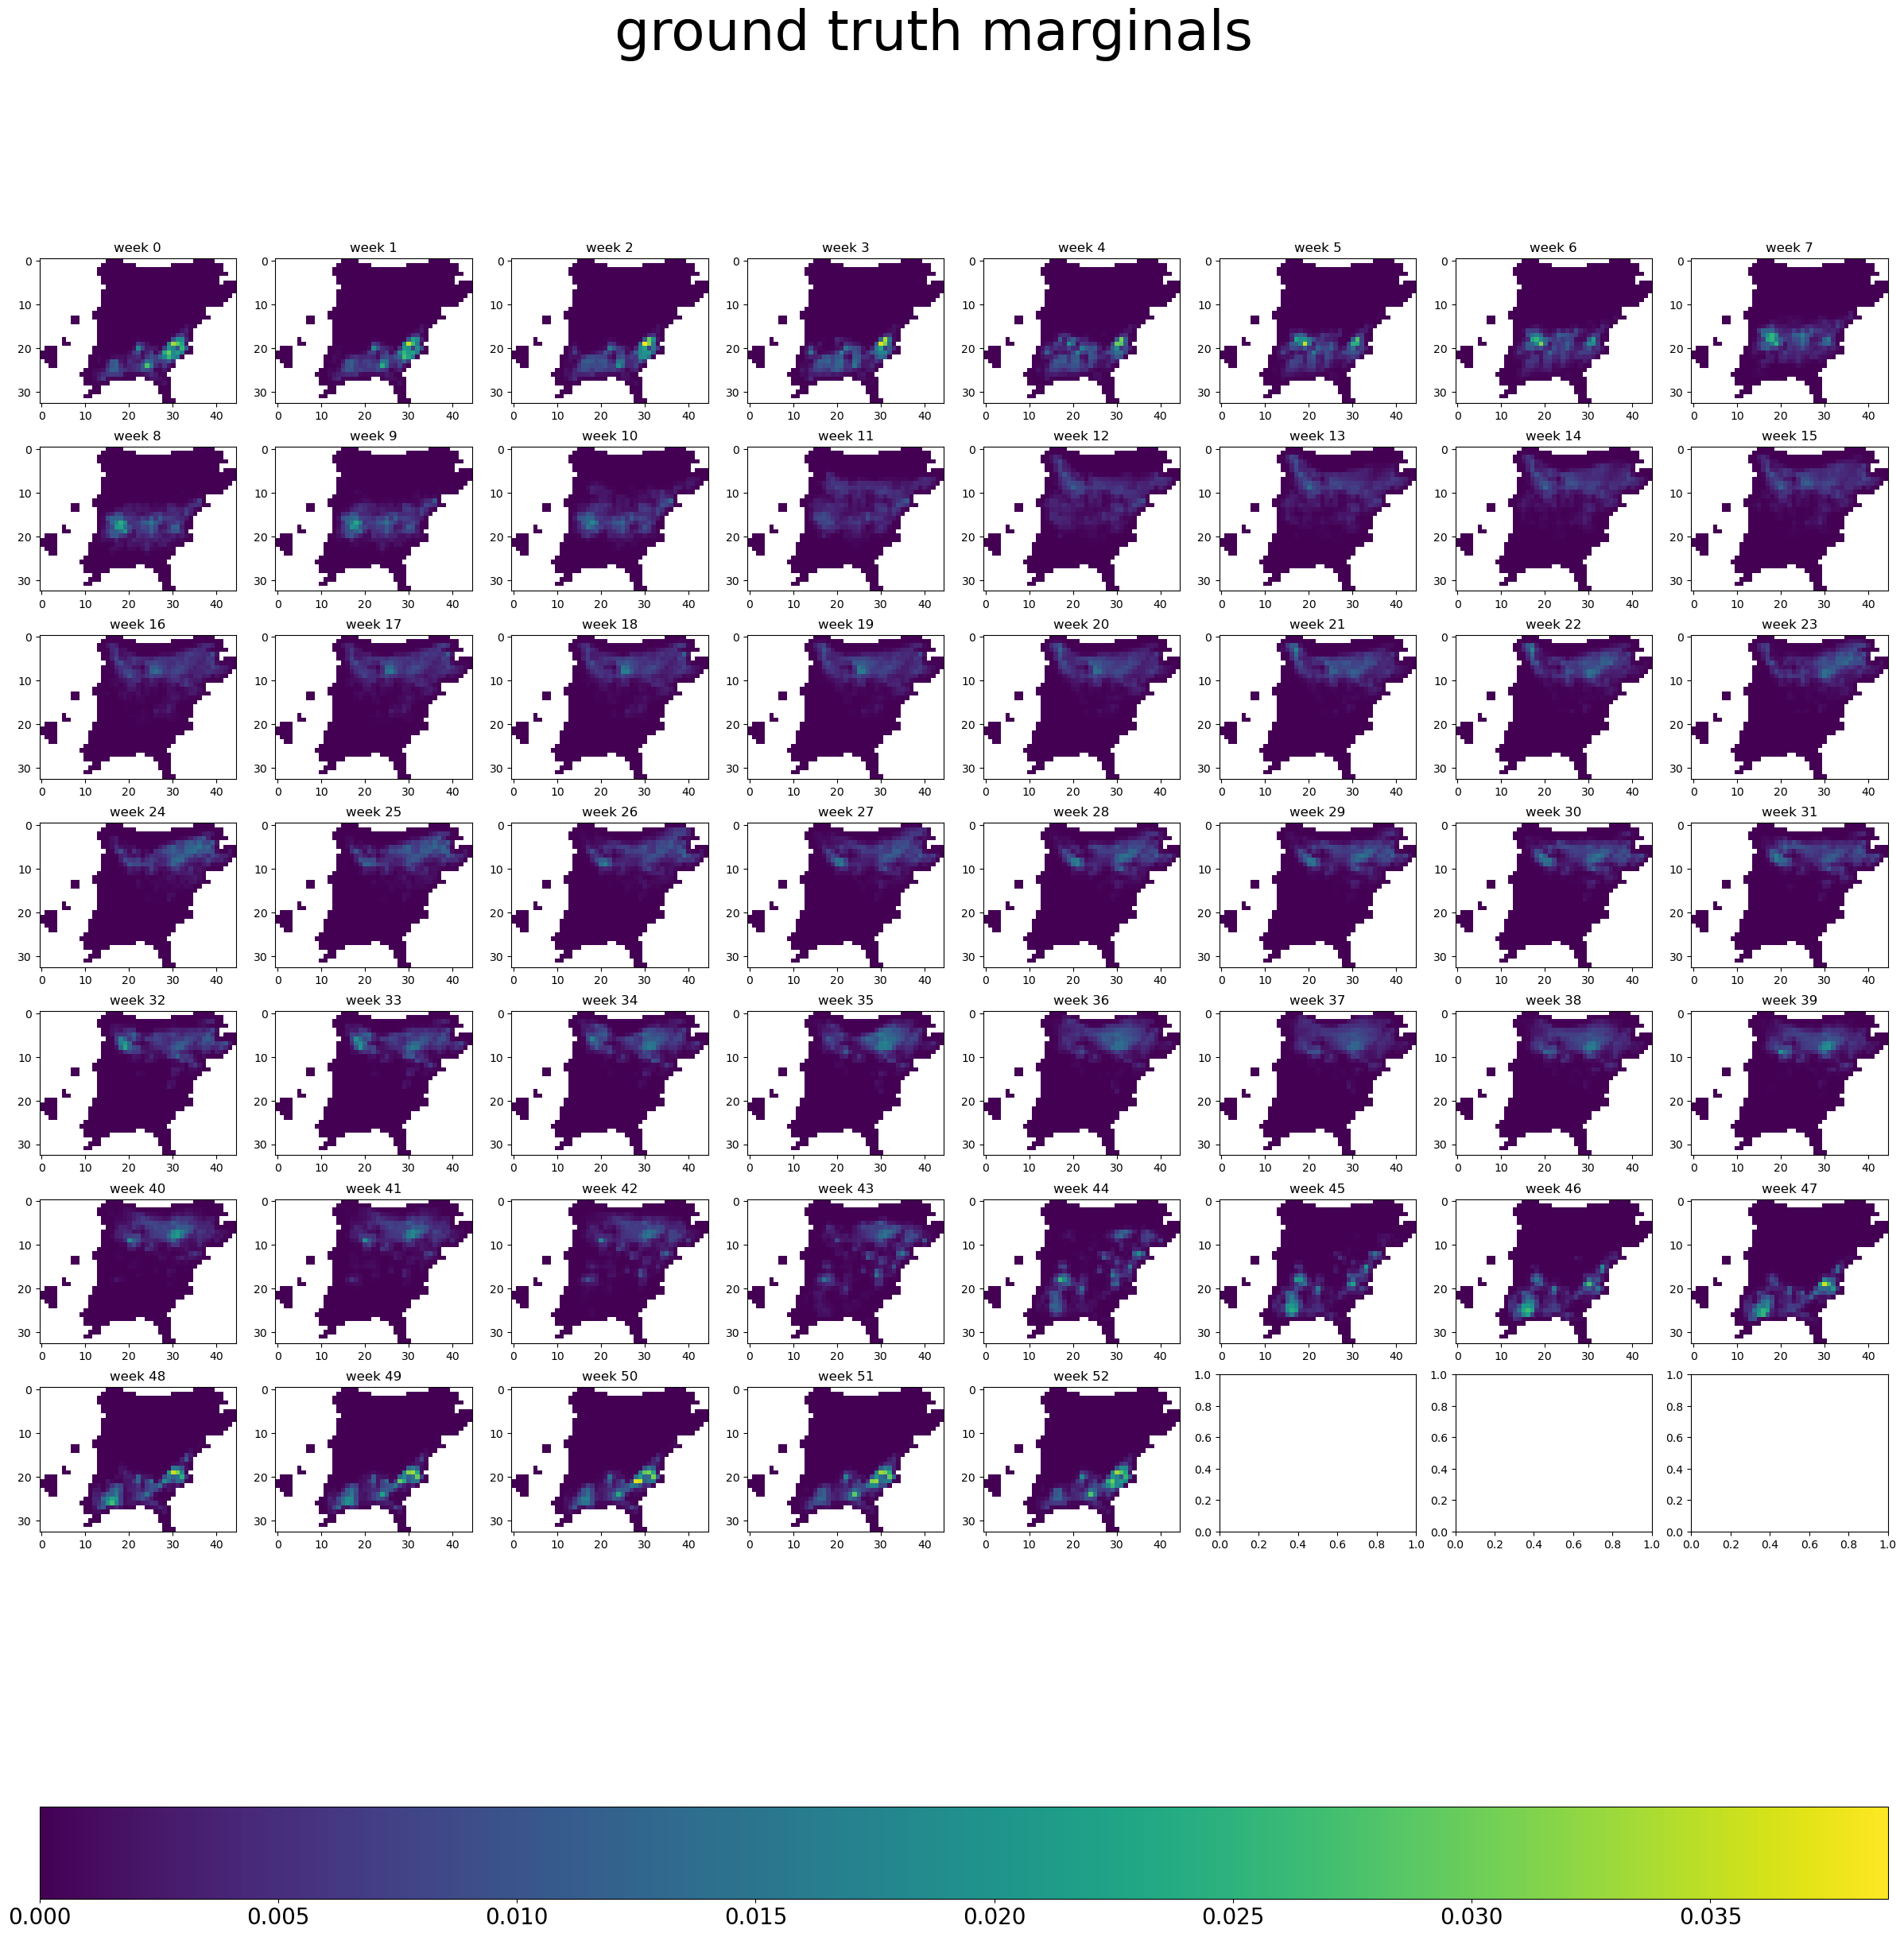

In [122]:
# plot ground truth at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in masked_densities])
for week, marginal in enumerate(masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

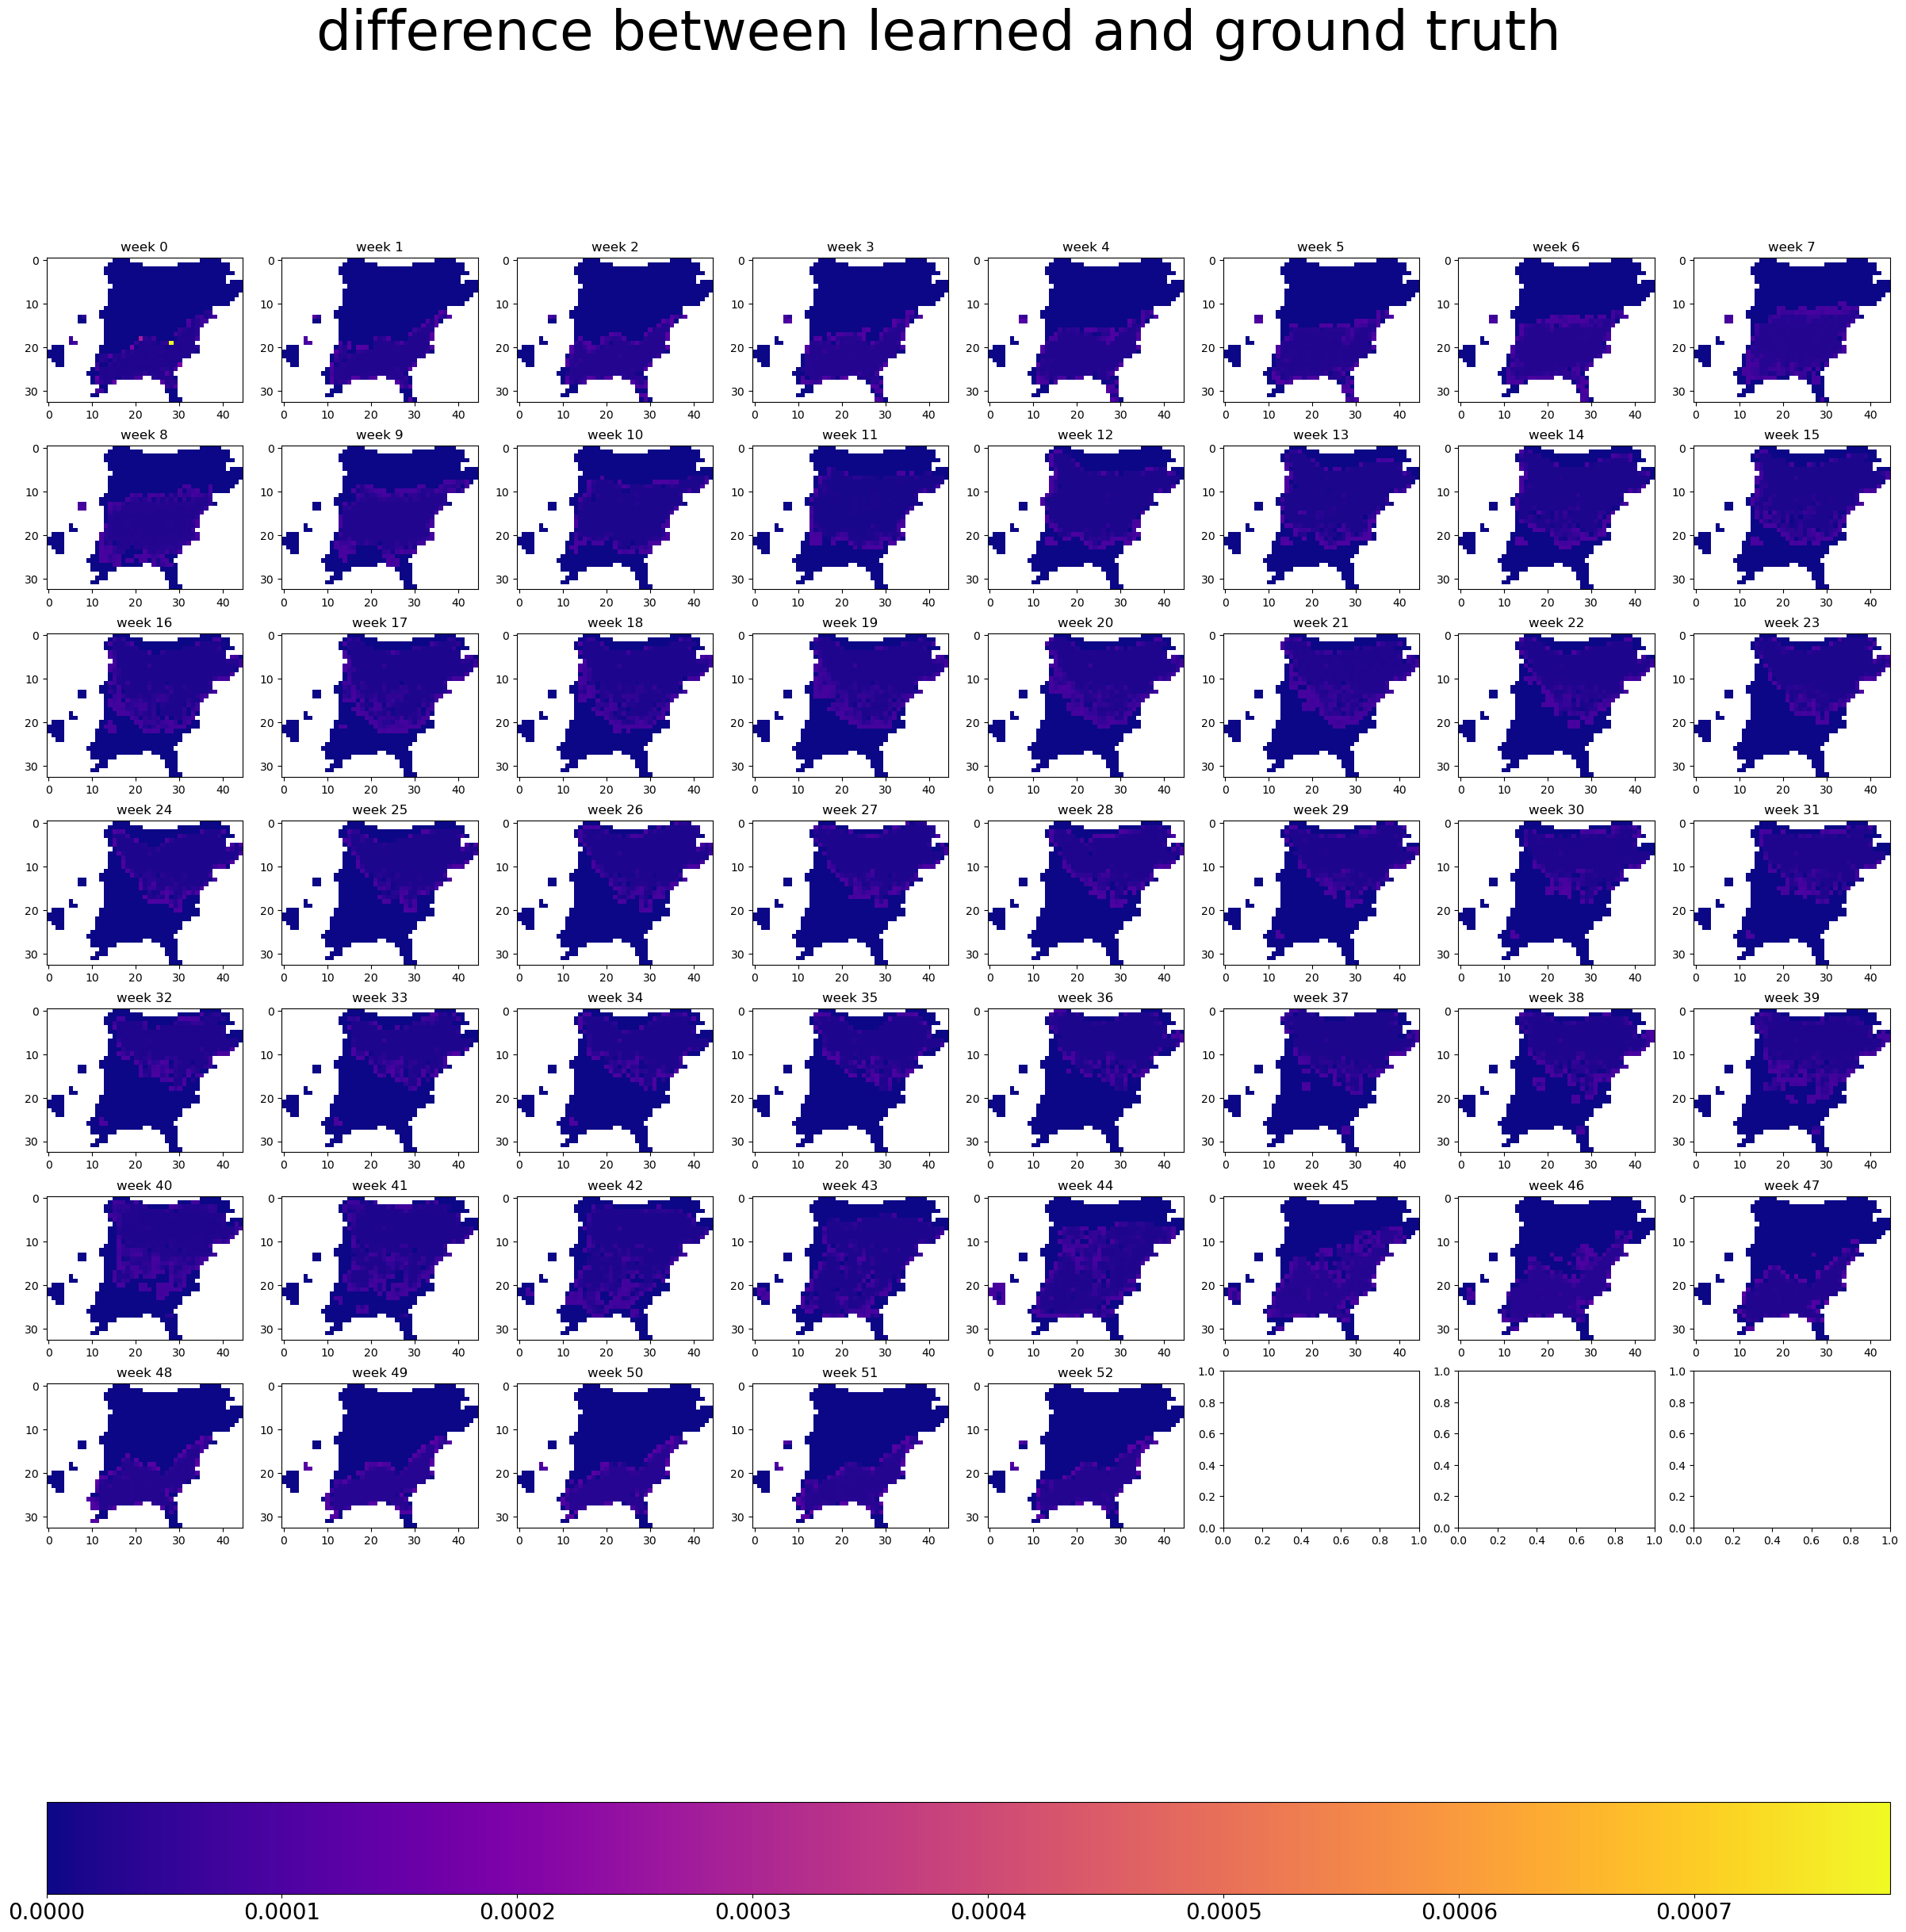

In [123]:
# plot difference between learned and ground truth for each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

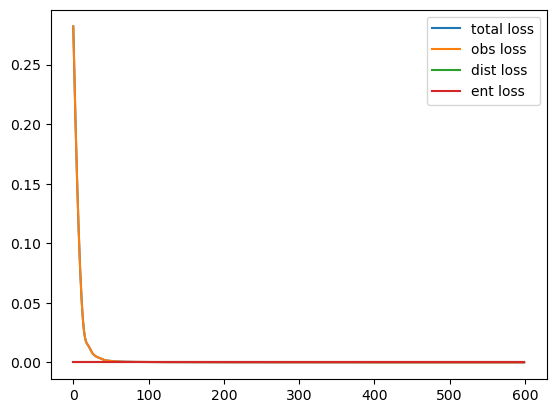

In [124]:
ent_weight = 0
dist_weight = 0
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['total'], label='total loss')
plt.plot(jnp.arange(num_iters), loss_dict['obs'], label='obs loss')
plt.plot(jnp.arange(num_iters), dist_weight * jnp.array(loss_dict['dist']), label='dist loss')
plt.plot(jnp.arange(num_iters), ent_weight * jnp.array(loss_dict['ent']), label='ent loss')
plt.legend()
plt.show()

### Experiment 3
- Train markov chain, plot w2 loss vals
- Learn only 5 weeks of st data
- epsilons fixed to 2 * eps_default
- ow: 1, dp: 0.4, dw: 0, ew: 0

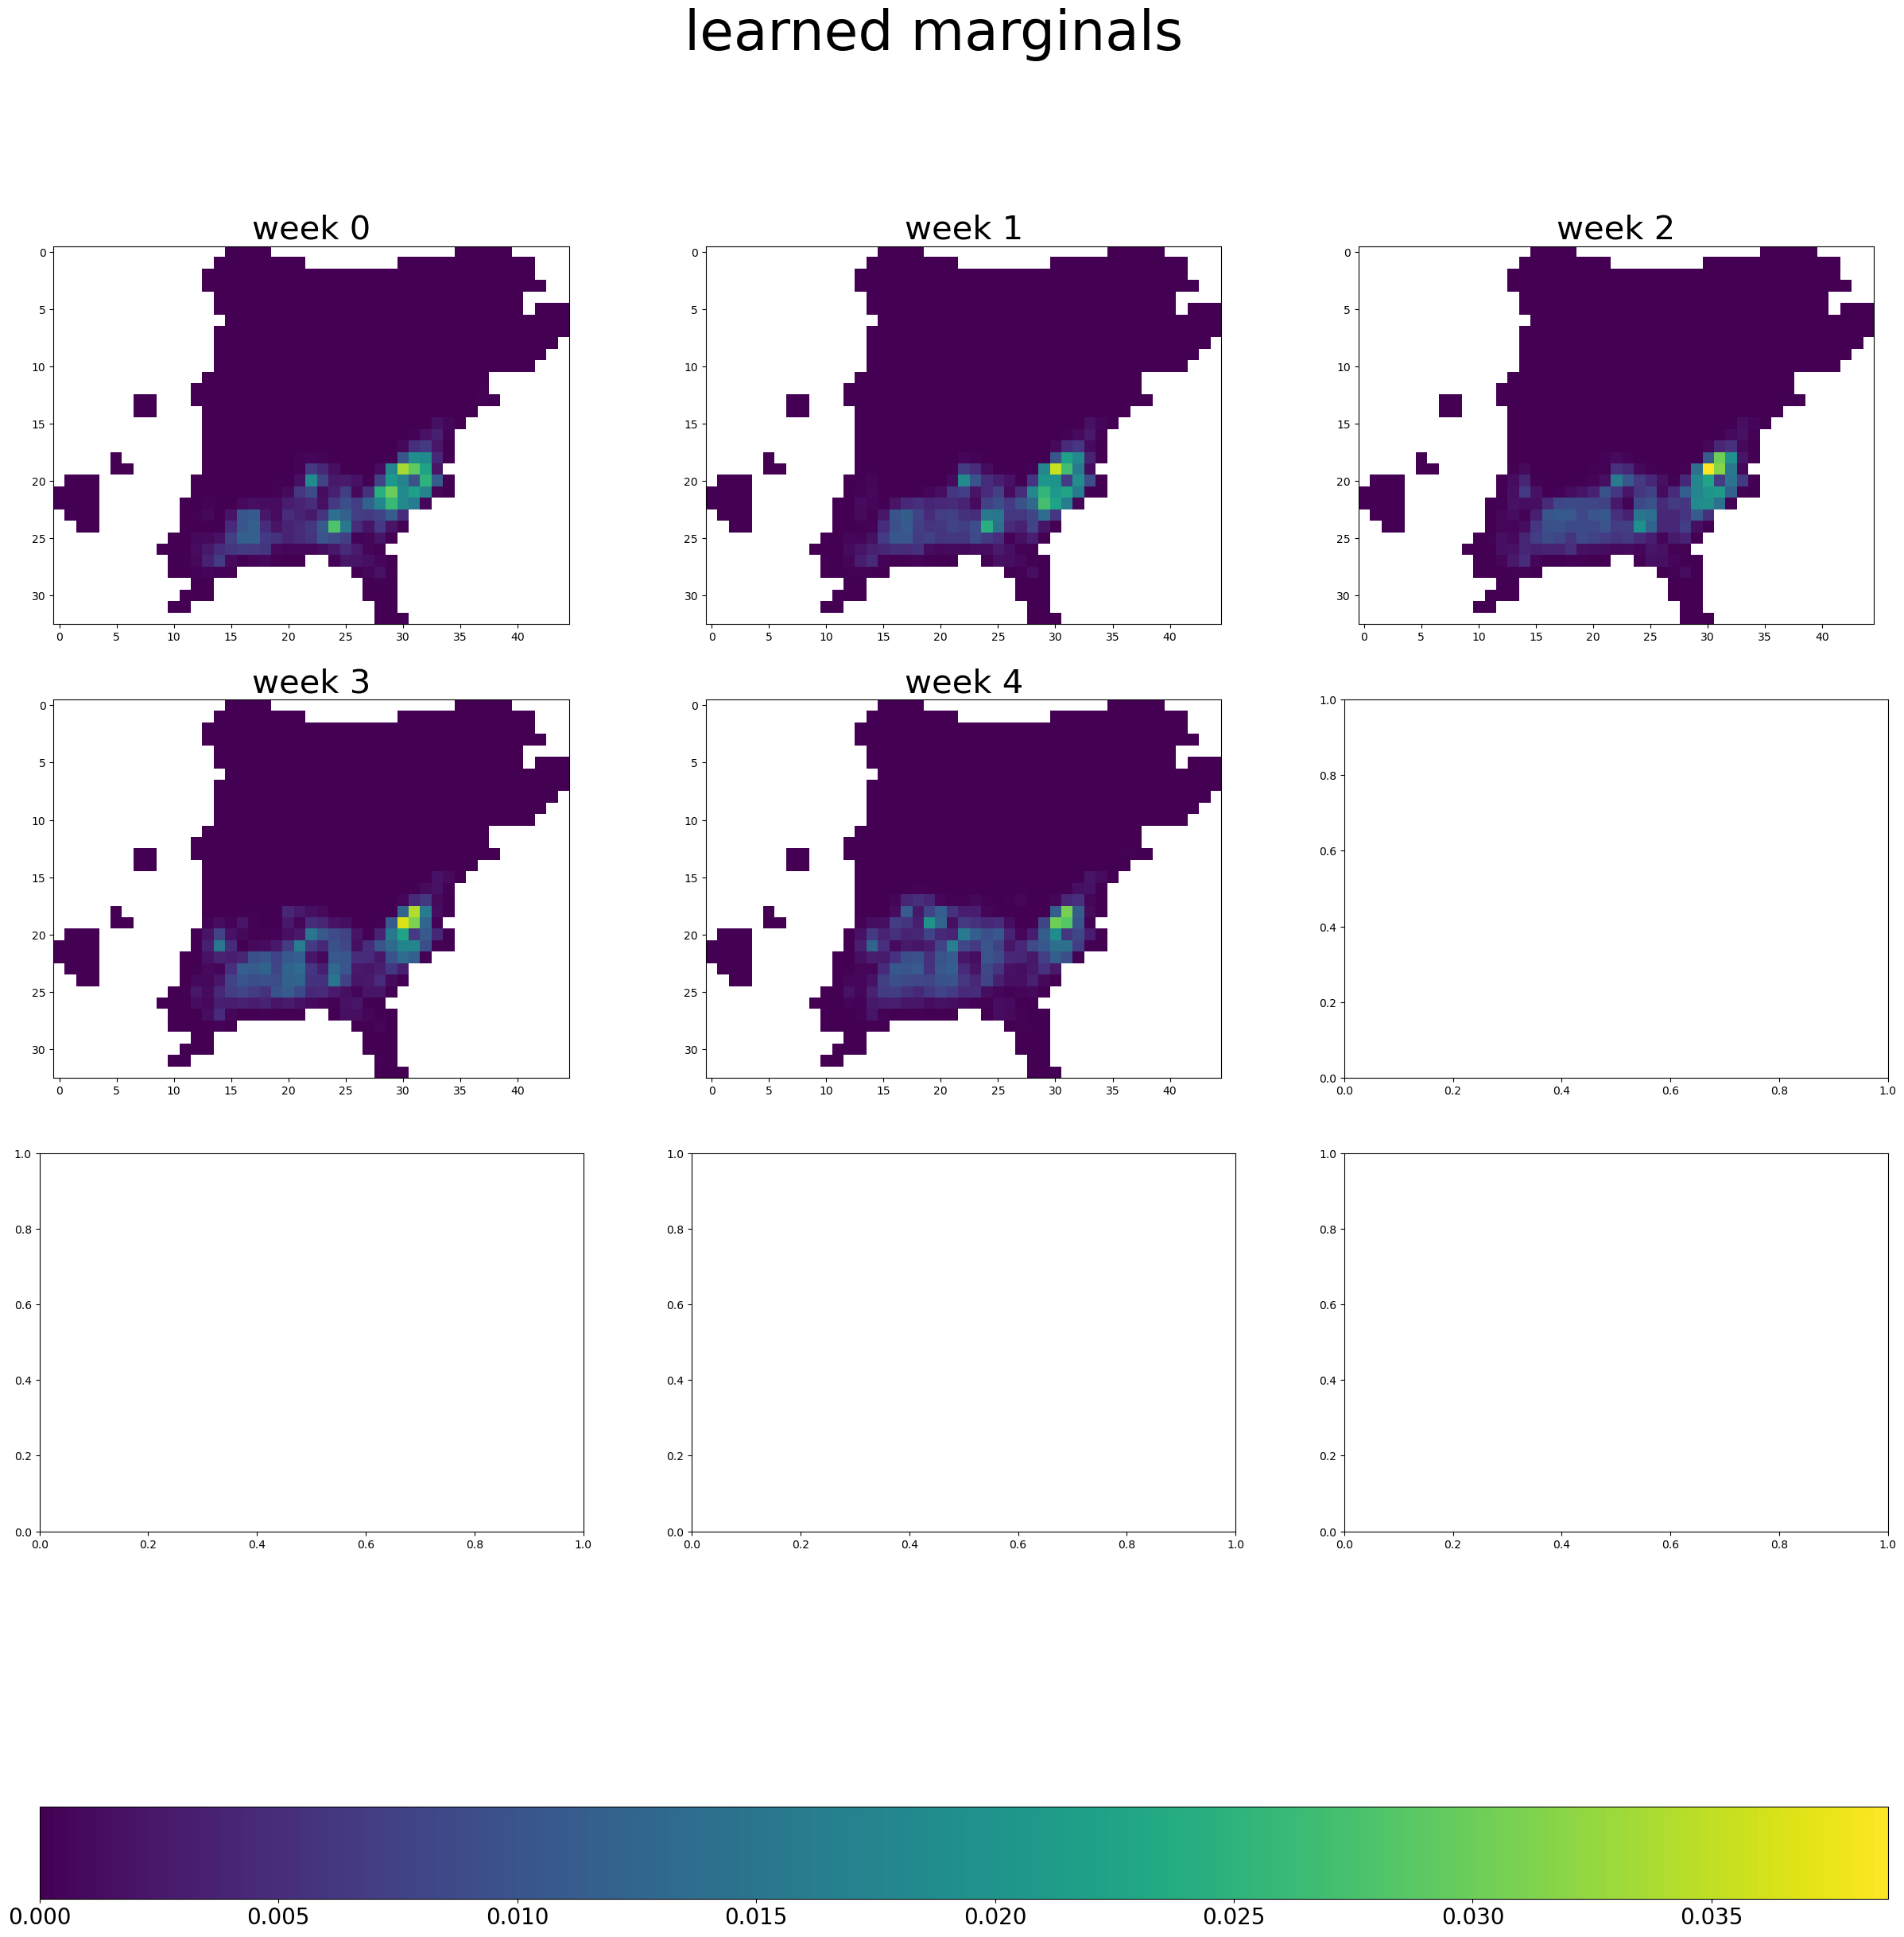

In [22]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex3_params_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex3_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex3_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    w2_loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()


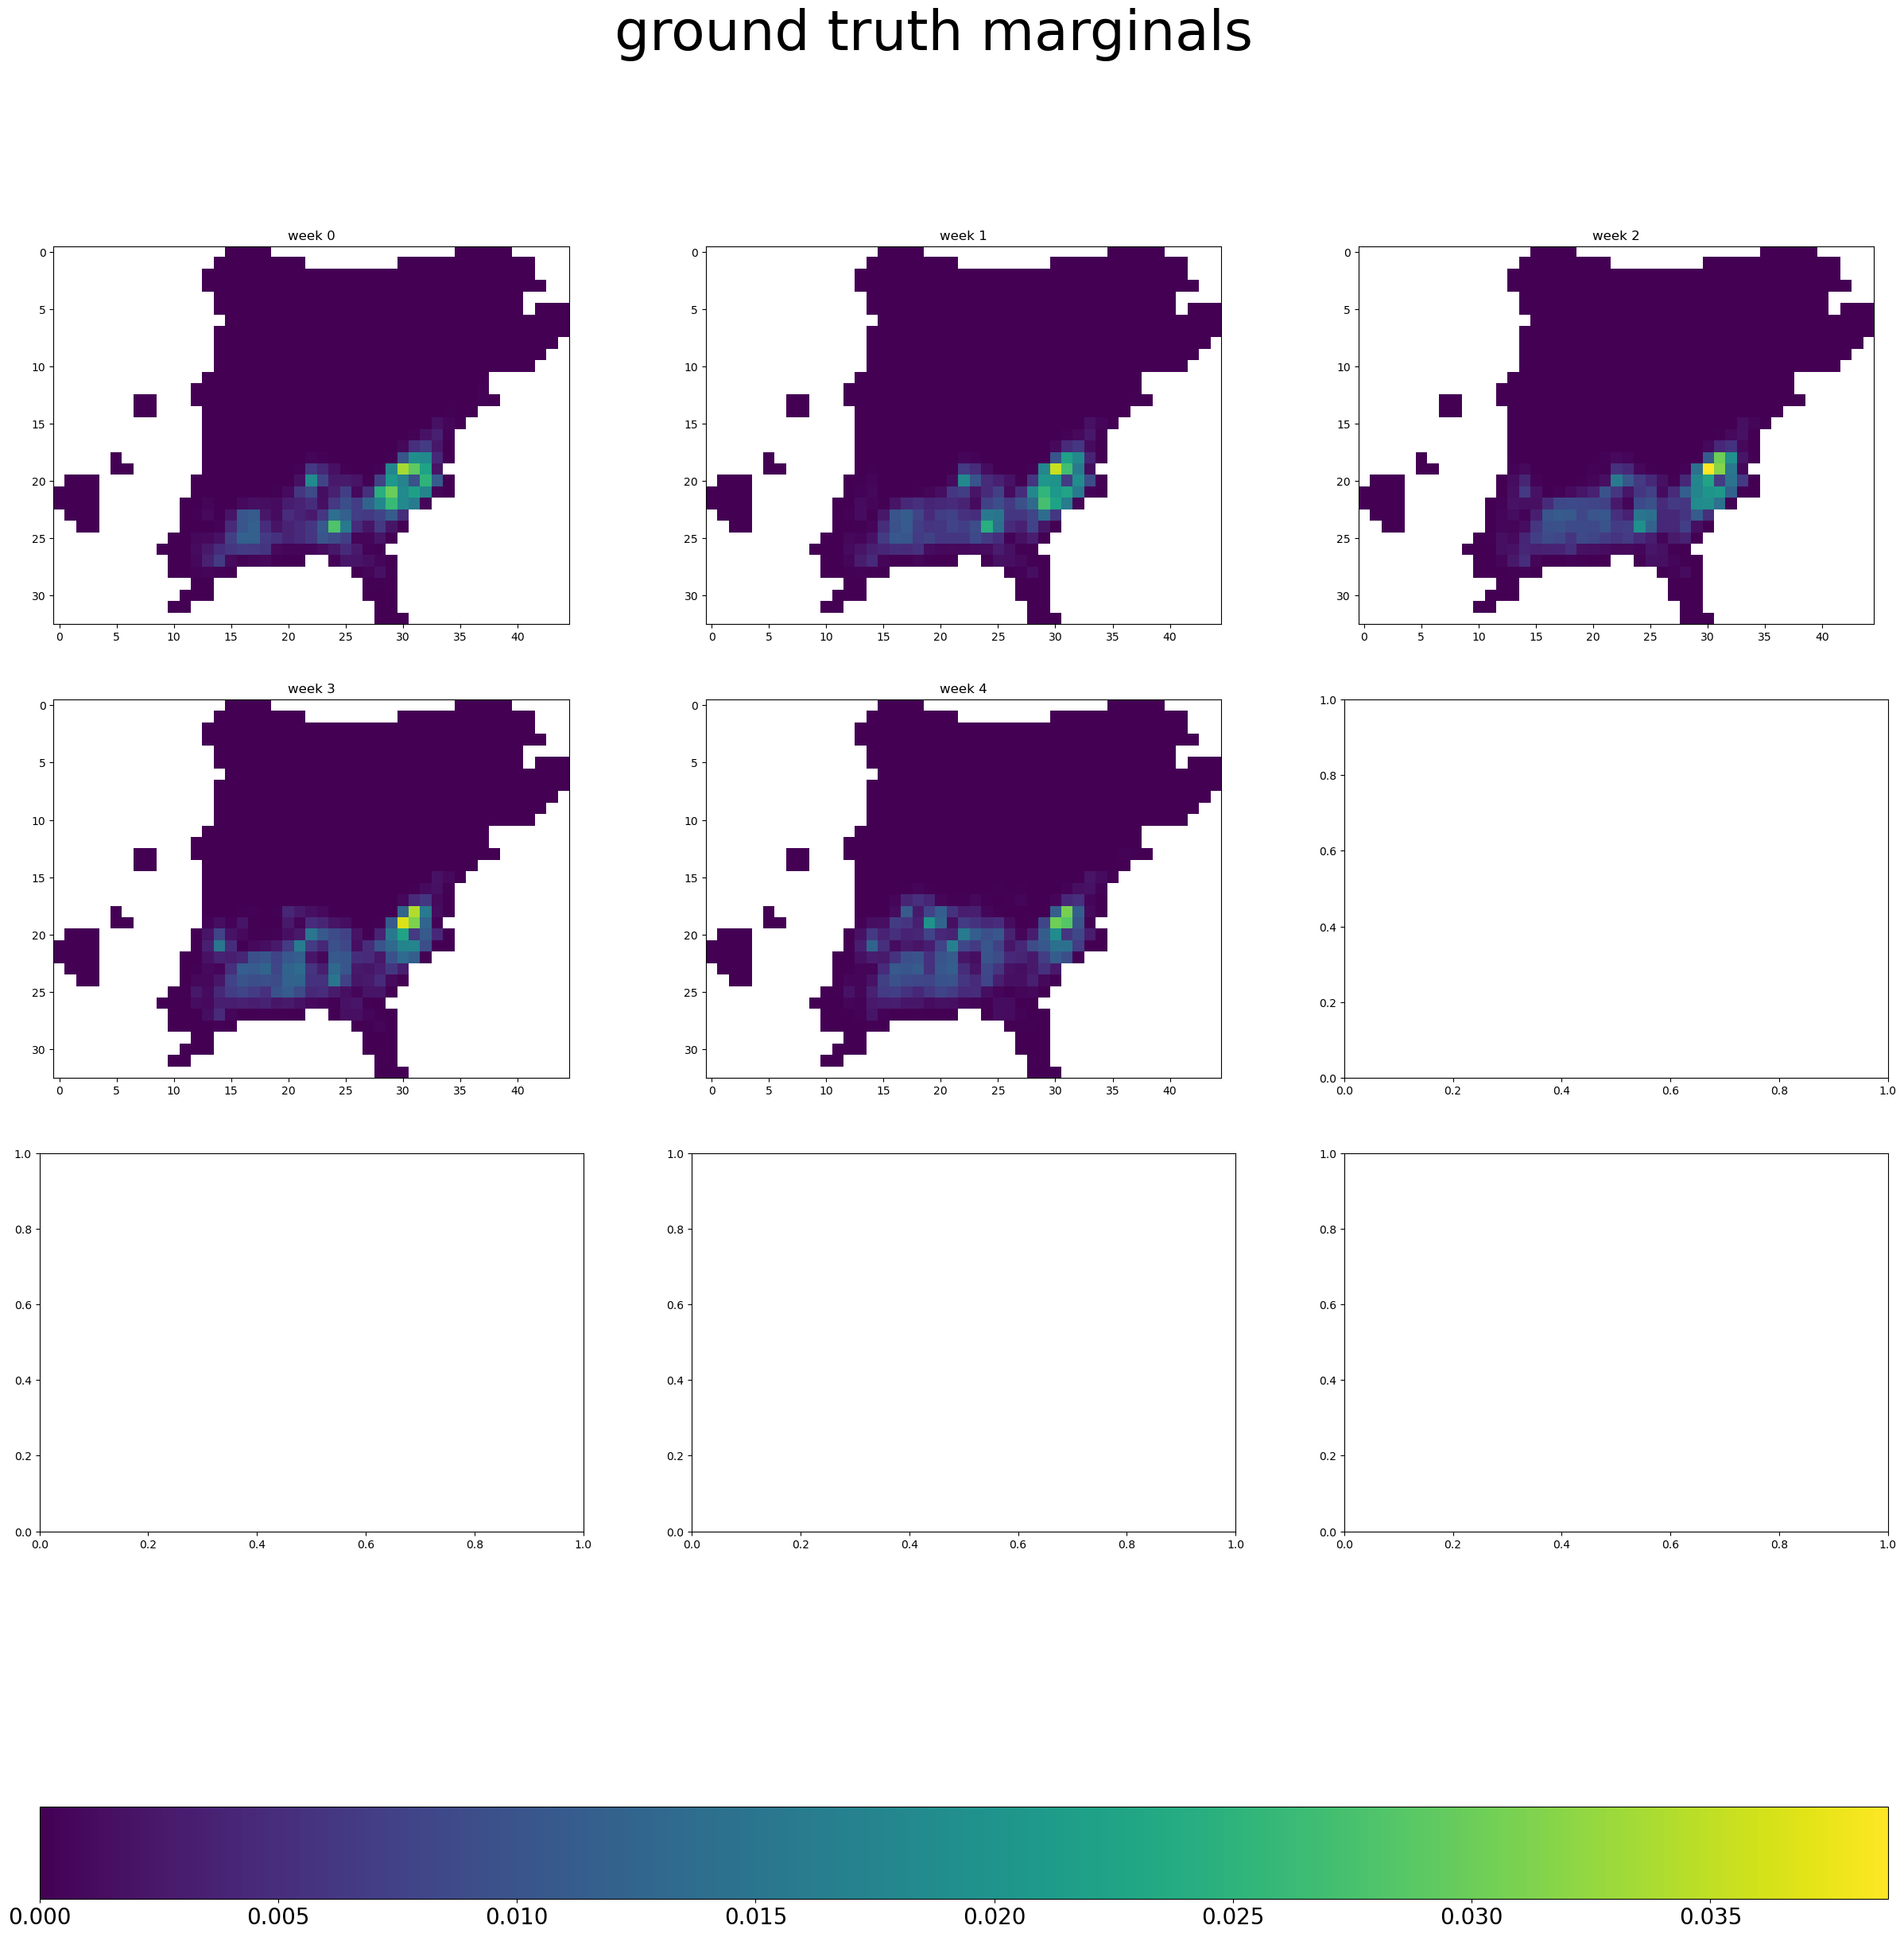

In [23]:
# plot ground truth at each week
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
ax_list = axes.flat
ex3_masked_densities = masked_densities[:len(params)]
vmin = 0
vmax = max([marginal.max() for marginal in ex3_masked_densities])
for week, marginal in enumerate(ex3_masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}",)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

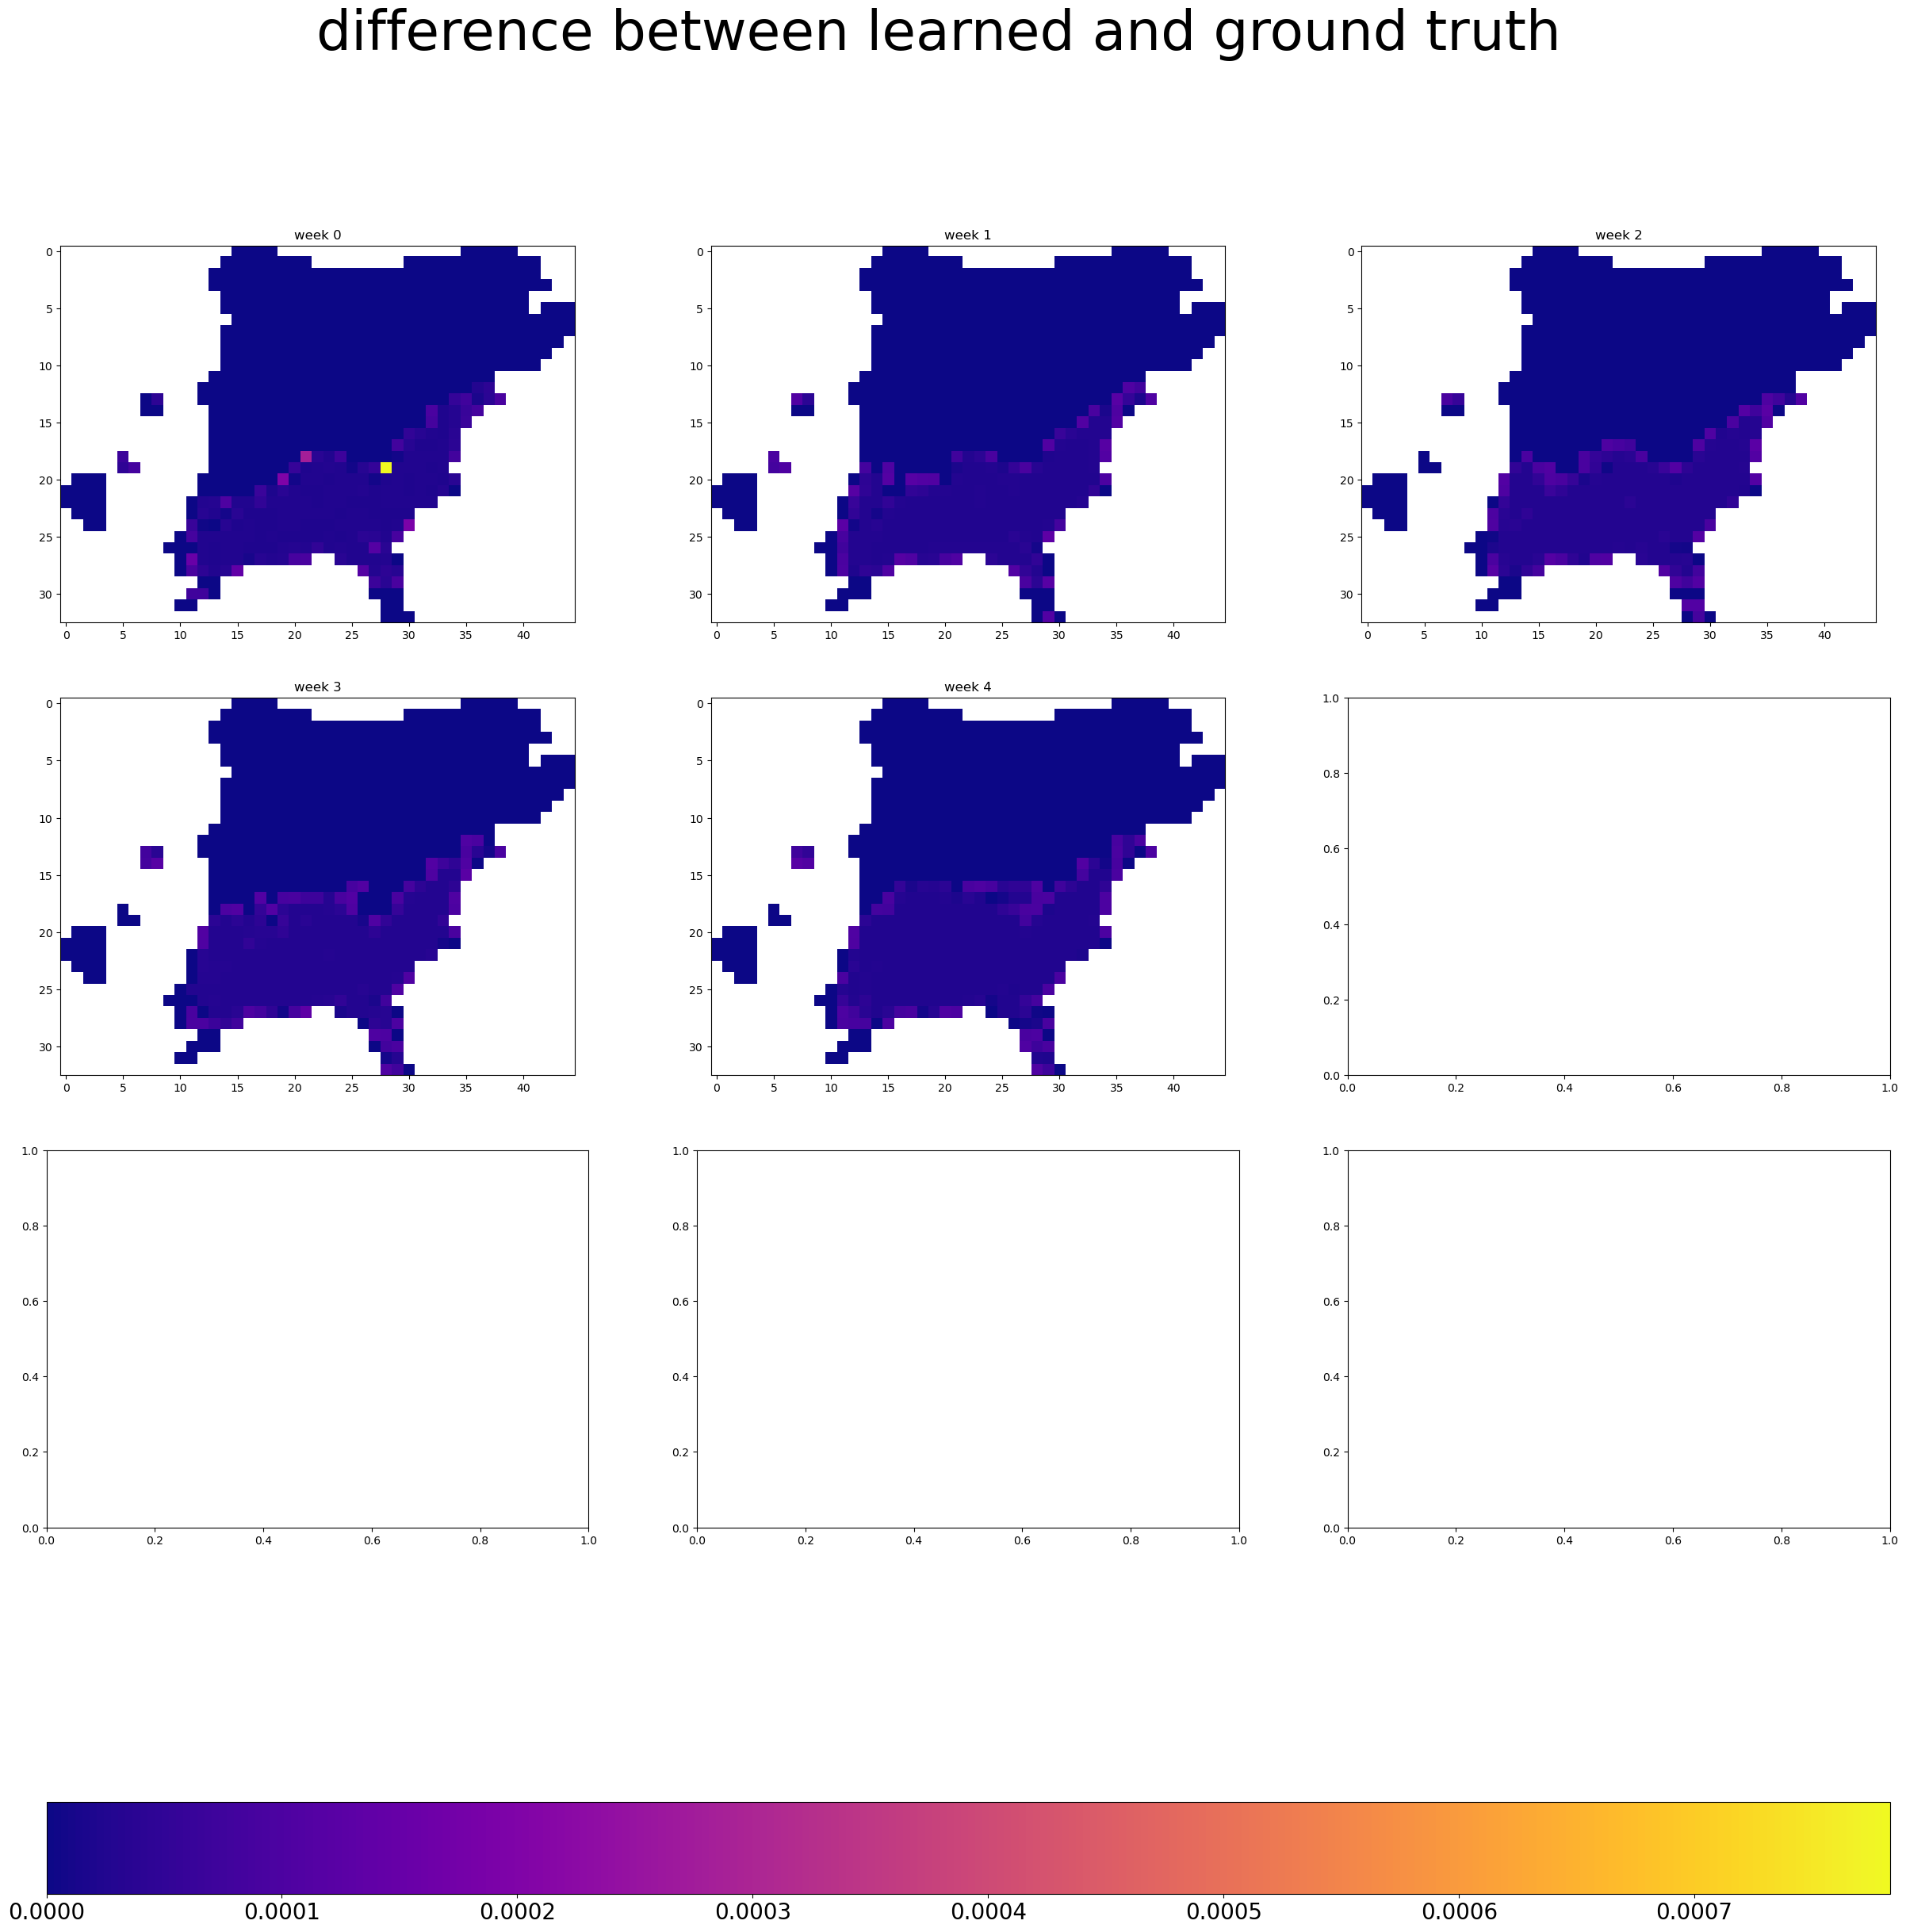

In [24]:
# plot difference between learned and ground truth for each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, ex3_masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(ex3_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

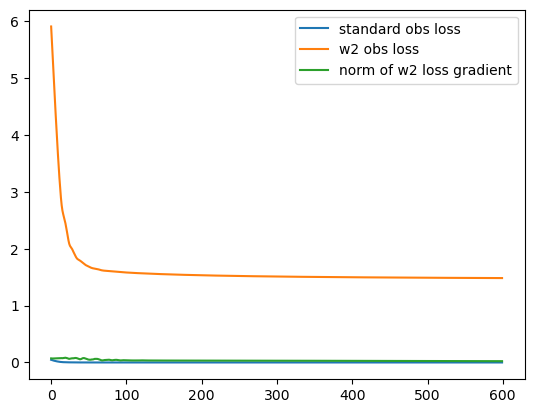

In [ ]:
ent_weight = 0
dist_weight = 0
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['obs'], label='standard obs loss')
plt.plot(jnp.arange(num_iters), w2_loss_dict['obs'], label='w2 obs loss')
plt.legend()
plt.show()

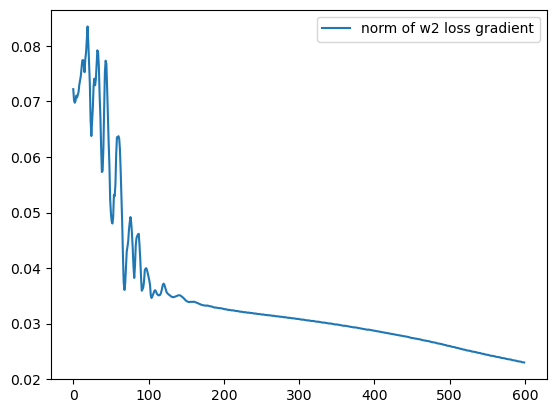

In [27]:
plt.plot(jnp.arange(num_iters), w2_loss_dict['norm_w2_grad'], label='norm of w2 loss gradient')
plt.legend()
plt.show()

#### Experiment 3.1
- Learn 23 weeks of ebird data
- epsilons fixed to 2 * `eps_default`
- ow: 1, dp: 0.4, dw: 0, ew: 0
- took ~50 mins on the cluster

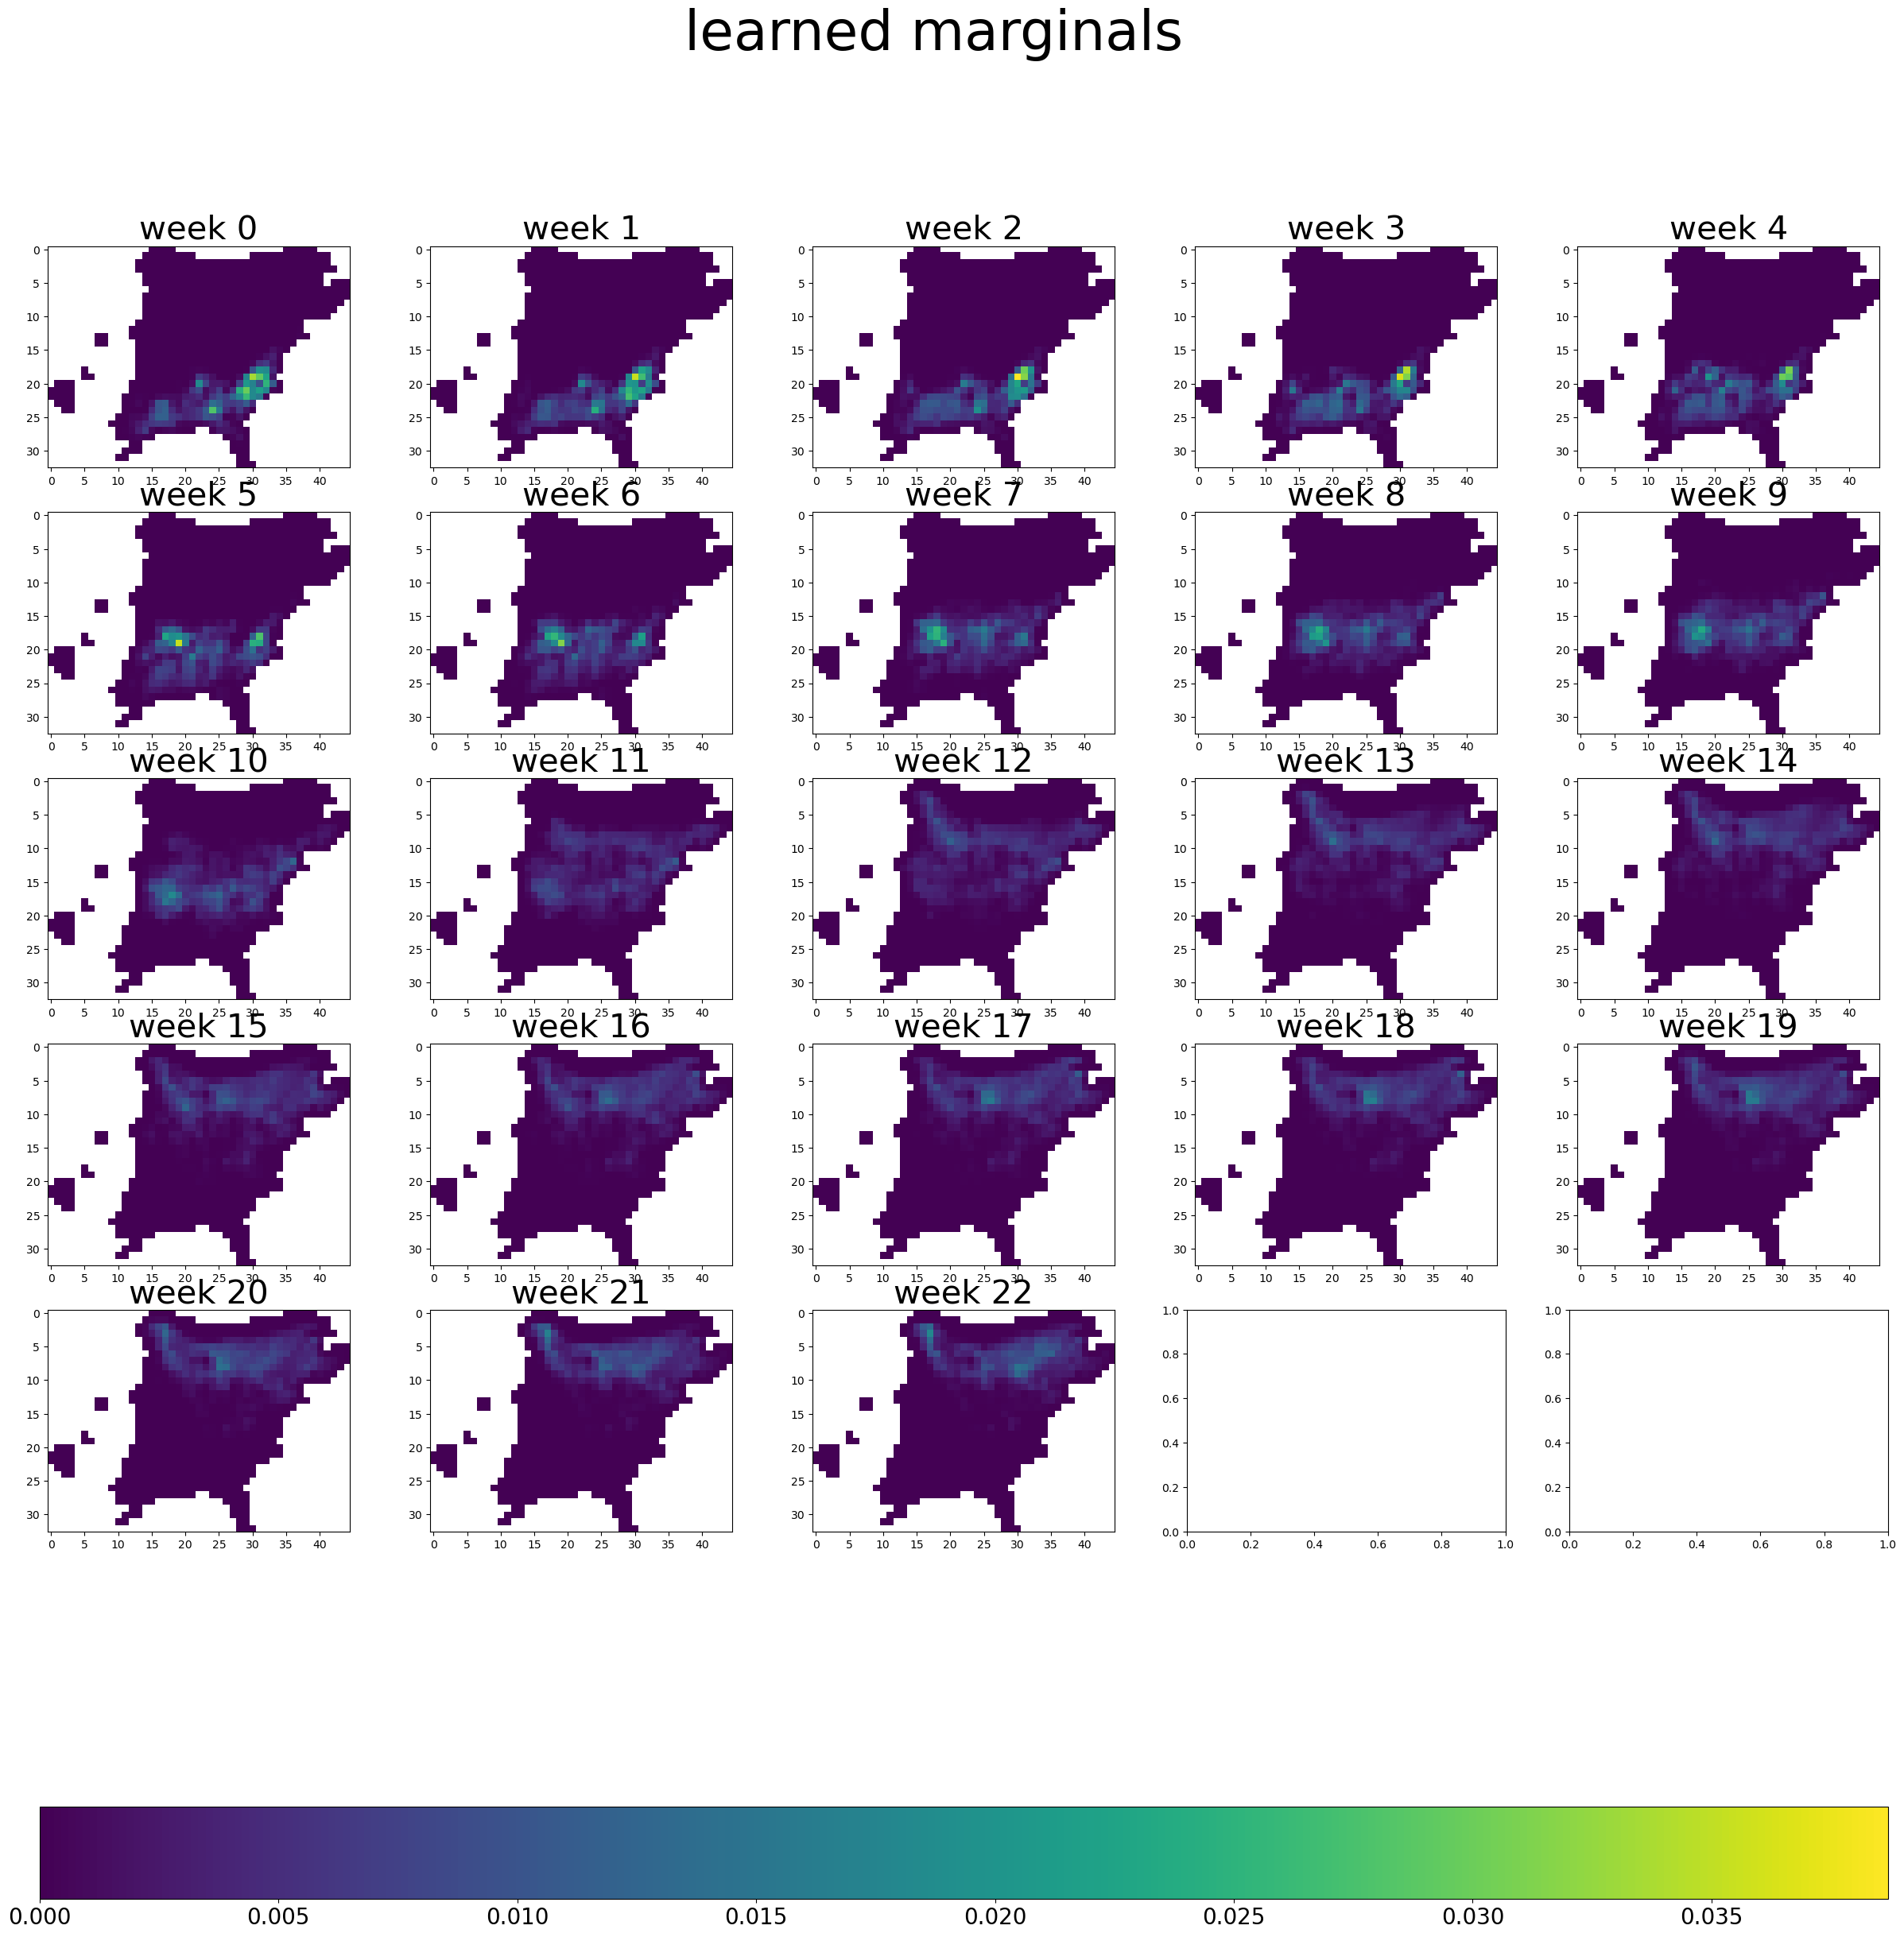

In [30]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex31_params_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex31_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex31_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    w2_loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(5, 5, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()


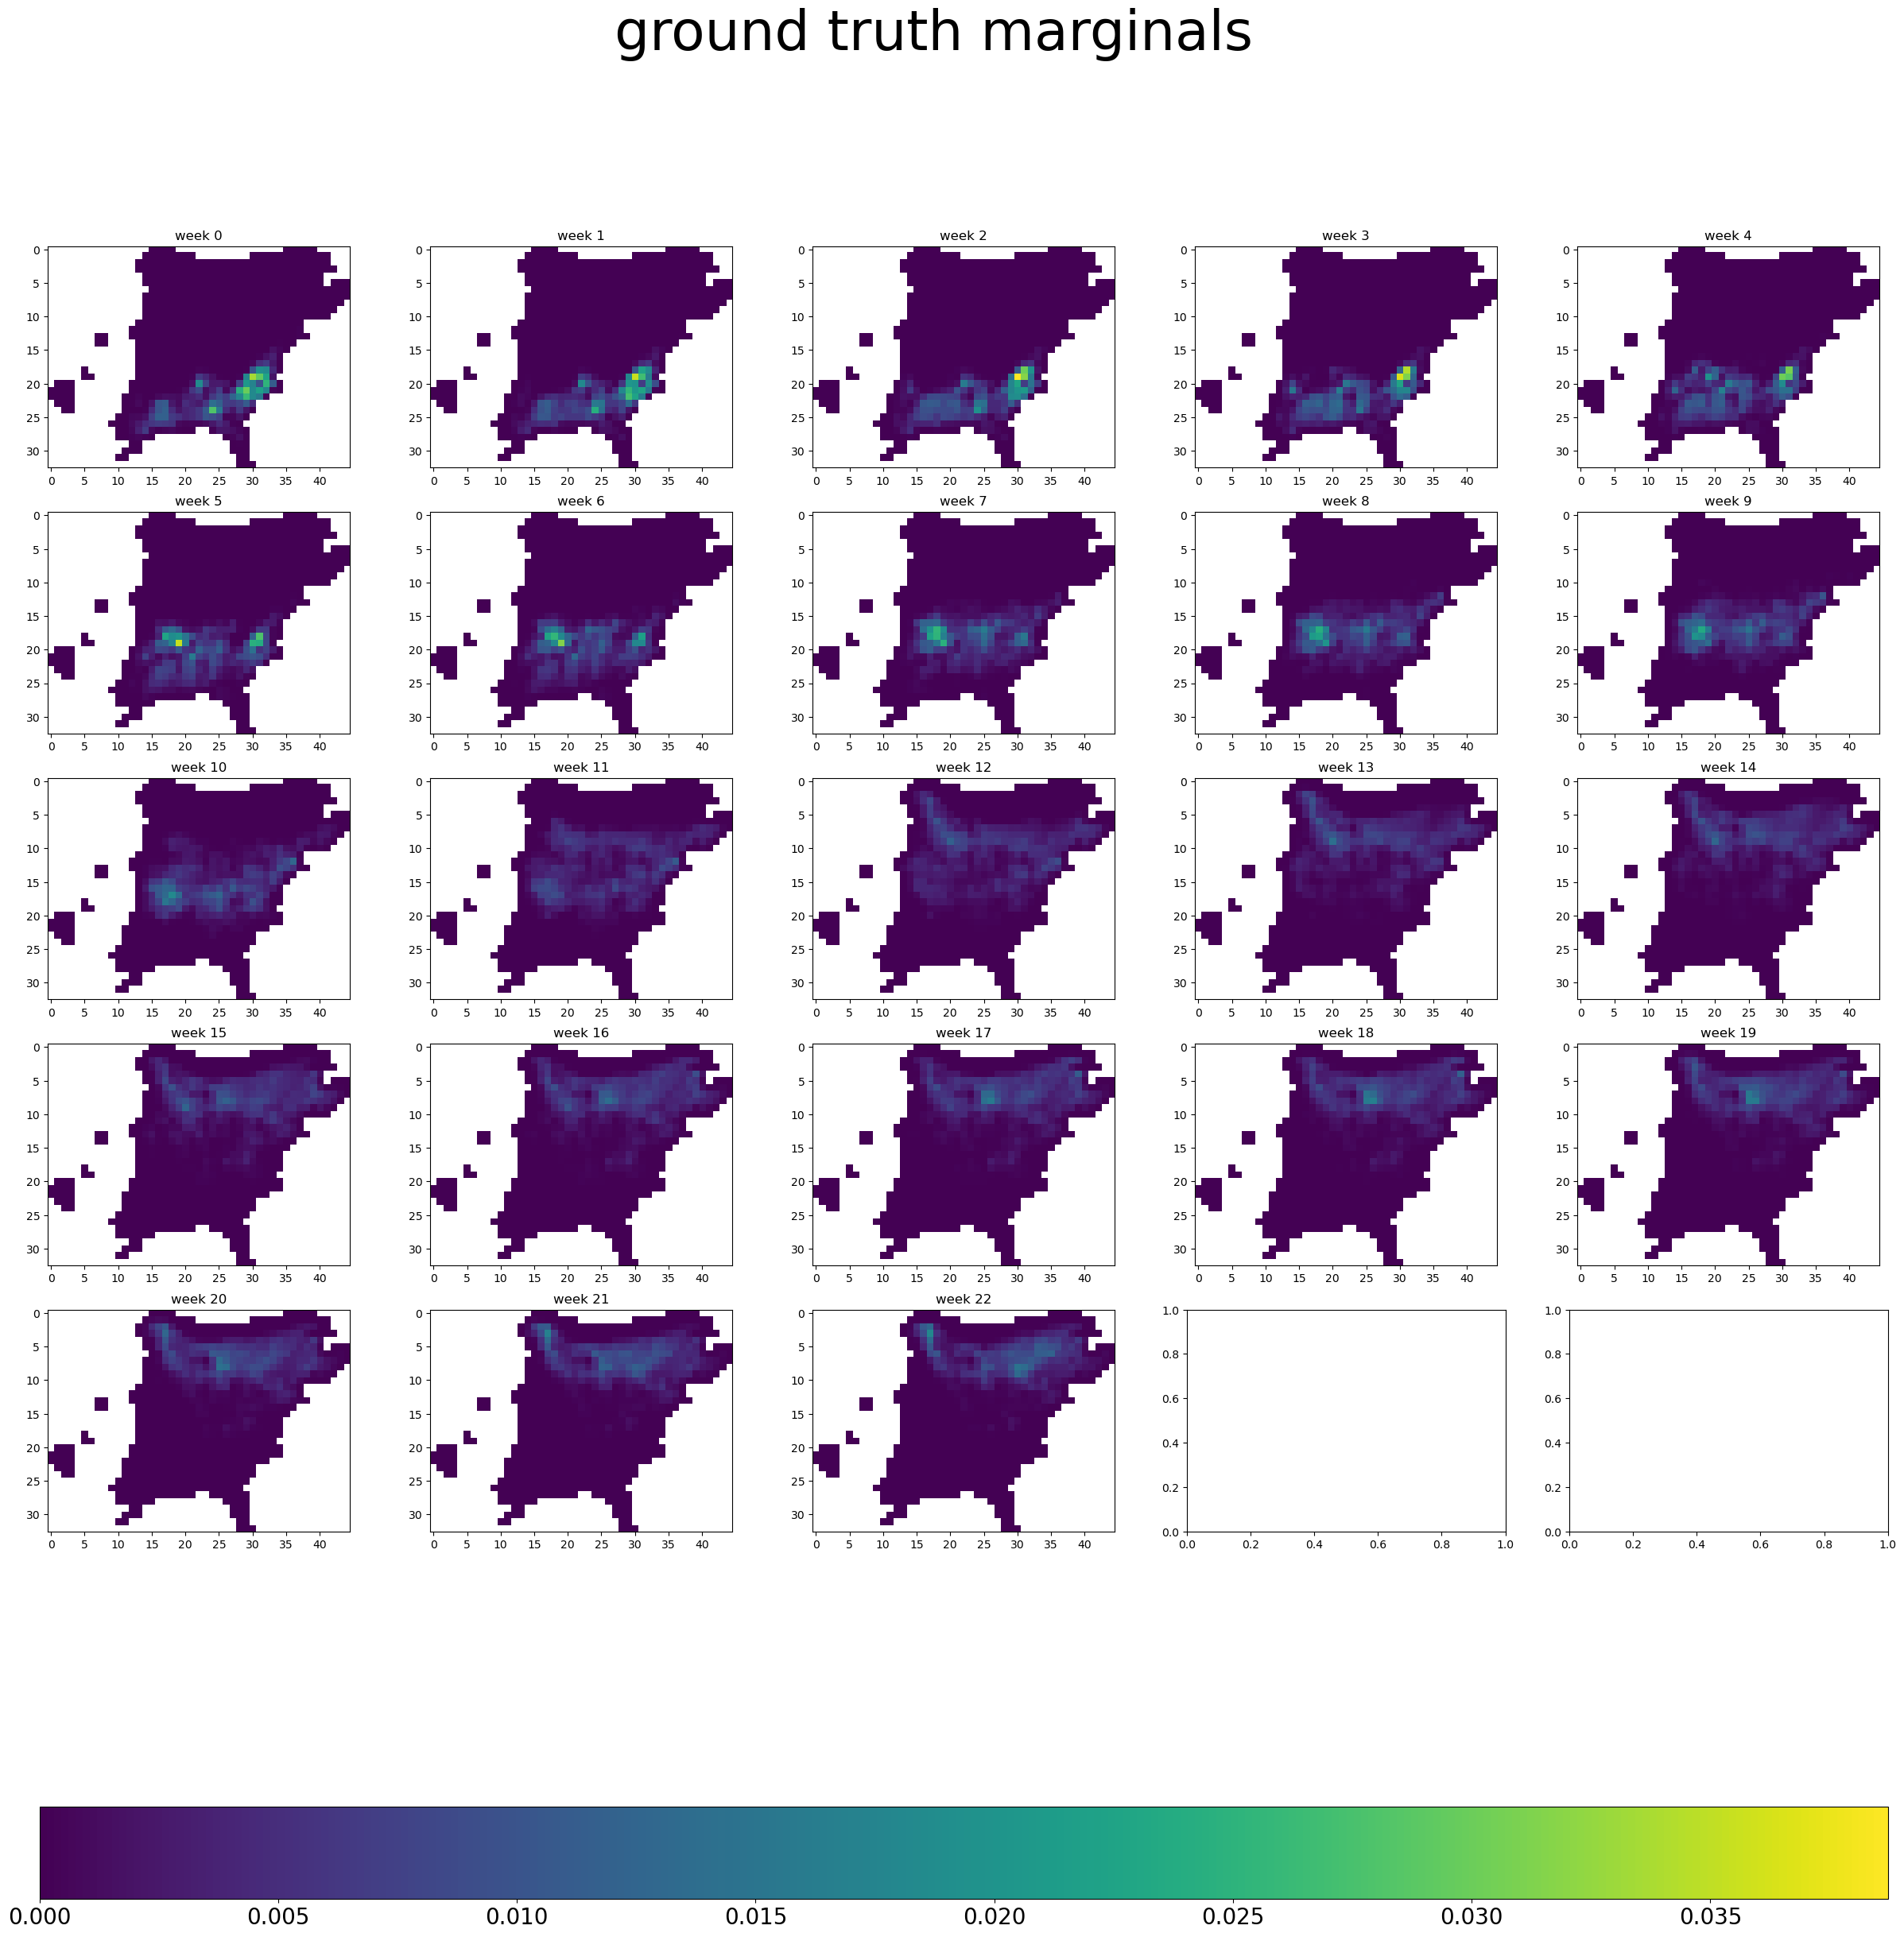

In [32]:
# plot ground truth at each week
fig, axes = plt.subplots(5, 5, figsize=(30, 30))
ax_list = axes.flat
ex3_masked_densities = masked_densities[:len(params)]
vmin = 0
vmax = max([marginal.max() for marginal in ex3_masked_densities])
for week, marginal in enumerate(ex3_masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}",)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

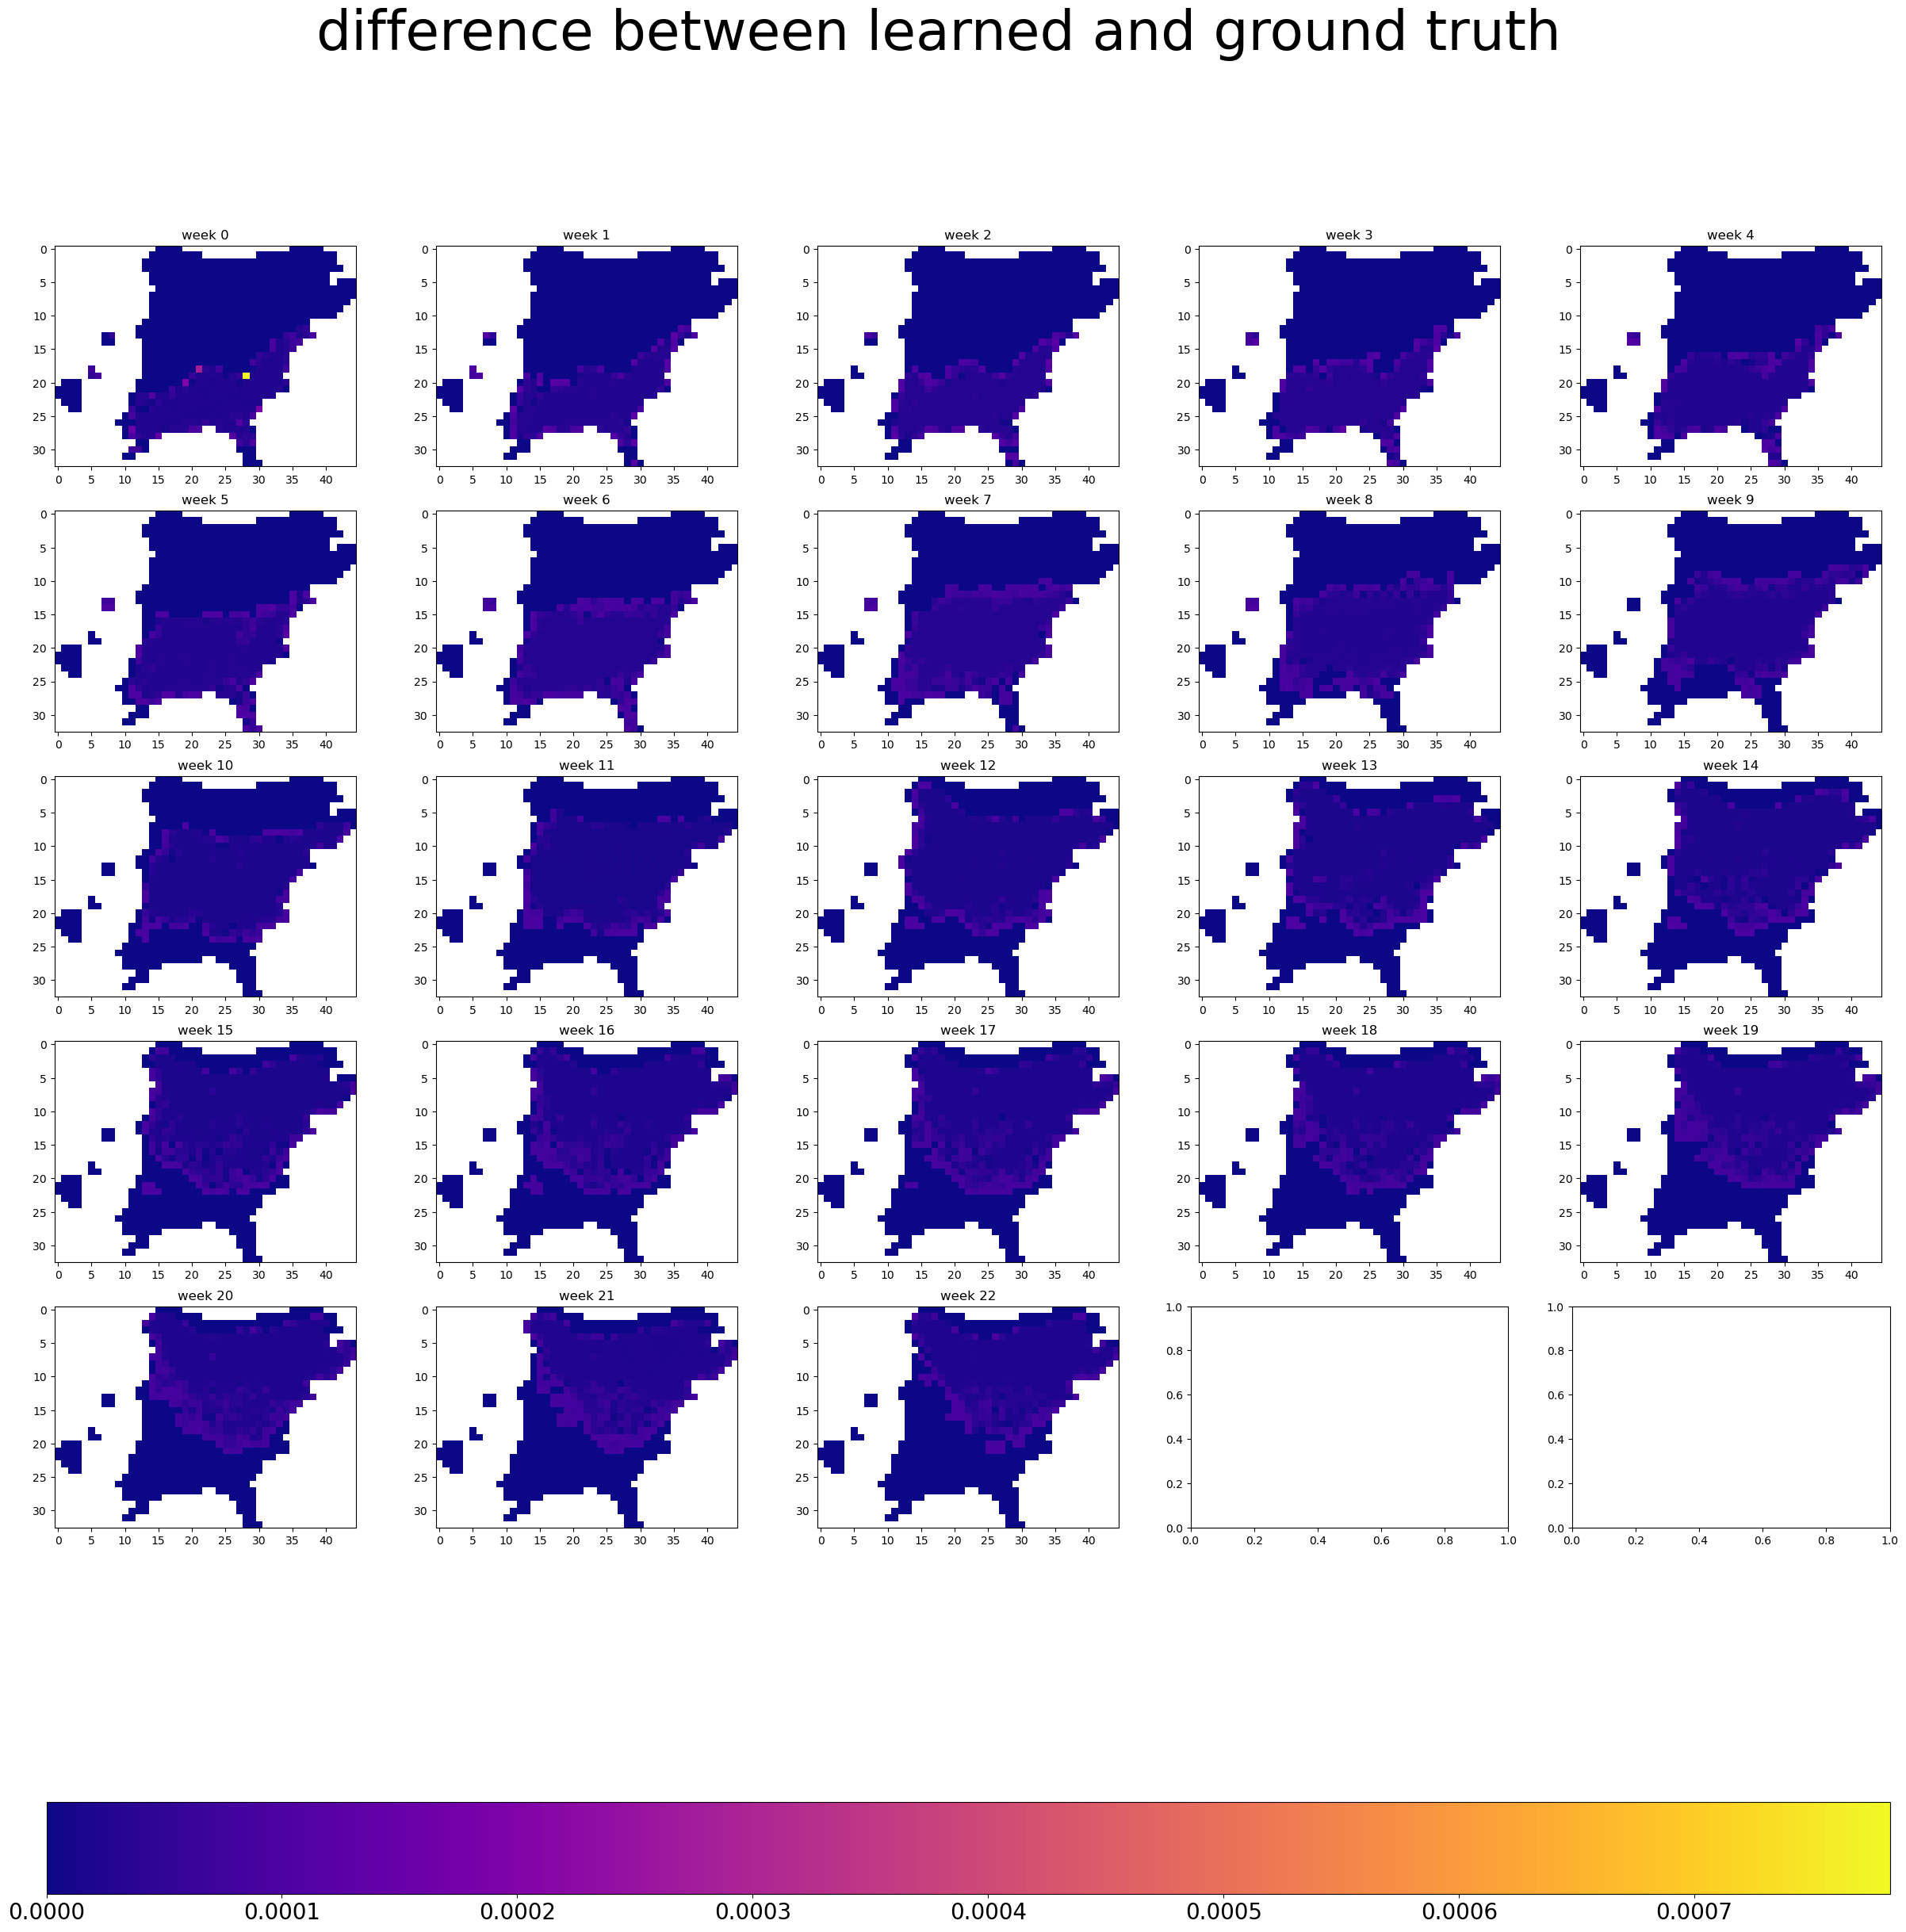

In [33]:
# plot difference between learned and ground truth for each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(5, 5, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, ex3_masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(ex3_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

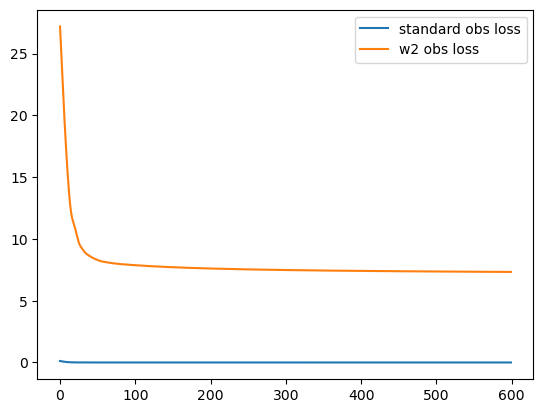

In [34]:
ent_weight = 0
dist_weight = 0
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['obs'], label='standard obs loss')
plt.plot(jnp.arange(num_iters), w2_loss_dict['obs'], label='w2 obs loss')
plt.legend()
plt.show()

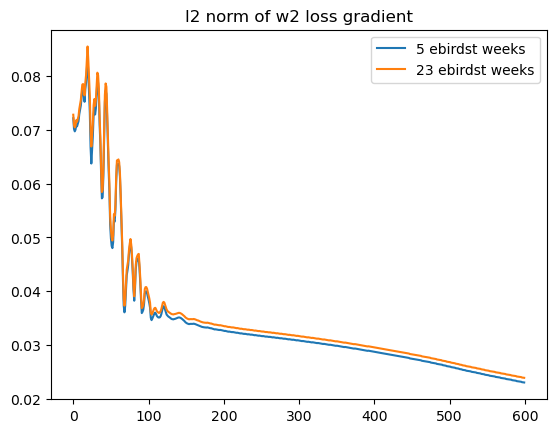

In [38]:
with open(os.path.join(experiment_dir, 'ex3_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    ex3_w2_loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex31_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    ex31_w2_loss_dict = pickle.load(f)

plt.plot(jnp.arange(num_iters), ex3_w2_loss_dict['norm_w2_grad'], label='5 ebirdst weeks')
plt.plot(jnp.arange(num_iters), ex31_w2_loss_dict['norm_w2_grad'], label='23 ebirdst weeks')
plt.legend()
plt.title("l2 norm of w2 loss gradient")
plt.show()